<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Guillermo Meza - Sebastian Muñoz </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

# 1. RNNs para series de tiempo

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


## 1.a Carga de datos y preprocesamiento.

##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [ ]:
username="gmezap"
key="67c43875aa87b82a44e920689eb419c7"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 74.9MB/s]
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
UNIXTime,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25


**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [ ]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear

(Int64Index([ 0,  5, 20, 25, 30, 45, 50, 55,  0,  5,
             ...
             10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
             ...
             23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
             ...
             366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
            dtype='int64', name='UNIXTime', length=32686))

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

### Respuesta

In [ ]:
import time
t1=time.time() 
#Shape = (24 horas x 12 intervalos de 5 min por hora x cantidad de datos , cantidad de parametros)
#definimos un matriz de nans que llenaremos de los datos del tiempo que existen, dejando en nan los demas
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object)
#arrego con los datetimes de cada registro.
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])]))

#Funcion que convierte los minutos de entero a string 
def min_to_str(min):
  if min==0: min="00"
  elif min==5: min="0"+str(min)
  else: min=str(min)
  return(min)

#convierte los timestamp en intervalos regulares de 5 minutos.
for i in range(new_data.shape[0]):
  hr=i//12-24*((i//12)//24)
  if hr==0: hr="00"
  elif 0<hr<10: hr="0"+str(hr)
  else: hr=str(hr)
  min=5*i-60*((5*i)//60)
  day=(i//12)//24
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00"


verbose,freq=True,12*24*5+12+1 # to see output
w_in=0

#aproxima los tiempos dejando en intervalos regulares de 5 minutos el dominio de las fechas
#si el dato no existe (nan) se salta al siguiente
for i in range(dataset.shape[0]):
  ind=dataset.index[i]
  min=ind.minute
  if i>0: past_min=dataset.index[i-1].minute
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute
  if min%5!=0:
    if (min+1)%5==0: min=min+1
    elif (min-1)%5==0: min=min-1
    elif past_min%5==0:
      if past_min!=55: min=past_min+5
      else: min=0
    elif next_min%5==0:
      if next_min!=0: min=past_min-5
      else: min=55
    elif (past_min-1)%5==0:
      if (past_min-1)!=55: min=past_min-1+5
      else: min=0
    else: print(past_min,min,next_min,"---keep expanding")
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:]
  found=0
  for w in range(w_in,w_in+new_data.shape[0]):
    if new_data[w,0][:-2] in ind:
      w_in=w
      found=1
      new_data[w,1:]=dataset.values[i,:]
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0])
      break
  if found==0:
    print("Error at ",ind)
    break

df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:25:00
2016-10-31 02:45:17-10:00 ----> 2016-10-31 02:45:00
2016-11-05 04:15:18-10:00 ----> 2016-11-05 04:15:00
2016-11-10 05:20:02-10:00 ----> 2016-11-10 05:20:00
2016-11-15 06:25:02-10:00 ----> 2016-11-15 06:25:00
2016-11-20 07:40:20-10:00 ----> 2016-11-20 07:40:00
2016-11-25 09:00:04-10:00 ----> 2016-11-25 09:00:00
2016-12-01 14:55:04-10:00 ----> 2016-12-01 14:55:00
2016-12-09 06:25:52-10:00 ----> 2016-12-09 06:25:00
2016-12-14 0

##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

In [ ]:
time=pd.to_datetime(df.index)
var_names=df.columns.tolist()
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
np.isnan((data)).sum()

7800

In [ ]:
l=[]
i=0
while i < len(nan_row_loc[0]):
  min=nan_row_loc[0][i]-1
  max=nan_row_loc[0][i]+1
  while max in nan_row_loc[0]:
    max+=1
  l.append((min,max))
  i+=max-min-1

### Respuesta:
Contemplamos dos situaciones:
1. Cuando existen 4 o menos missing values consecutivos, estos se rellenan con una interpolacion lineal de los valores adyacentes al intervalo. (dentro del mismo dia)
2. Si existen más de 4 missings consecutivos rellenamos con el promedio de los datos de los dias adyacentes a esa misma hora.

Elegimos este reemplazo dado que consideramos que 4 valores son una cantidad prudente para hacer una regresion lineal, mientras que un "parche" con mas de 4 valores, afecta mas a la distribucion de comportamiento de la curva. 

In [ ]:
for intervalo in l:
  if intervalo[1]-intervalo[0]<=4:
    for parametro in range(6):
      x1=intervalo[0]
      x2=intervalo[1]
      y1=data[x1][parametro]
      y2=data[x2][parametro]
      for nan_index in range(1,x2-x1):
        x=x1+nan_index
        data[x][parametro]=(y2-y1)/(x2-x1)*(x-x1)+y1
for intervalo in l:
  if intervalo[1]-intervalo[0]>4:
    for nan_index in range(intervalo[0]+1,intervalo[1]):
      diaprev=nan_index-288
      diasig=nan_index+288
      while diasig in nan_row_loc[0]:
        diasig+=288
      for parametro in range(6):
        data[nan_index][parametro]=(data[diaprev][parametro]+data[diasig][parametro])/2


**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [ ]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]
time_hr=pd.to_datetime(time_hr)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [ ]:
data_tr, time_tr = data_hr[:int(data_hr.shape[0]*0.7)],time_hr[:int(data_hr.shape[0]*0.7)]
data_val, time_val = data_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)],time_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)]
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):]

In [ ]:
data_tst.shape

(425, 6)

##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

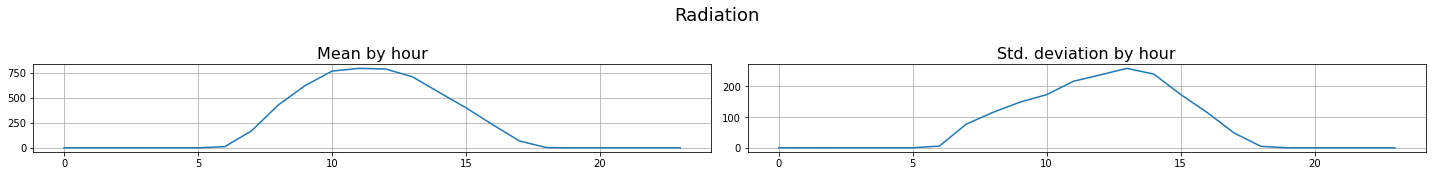

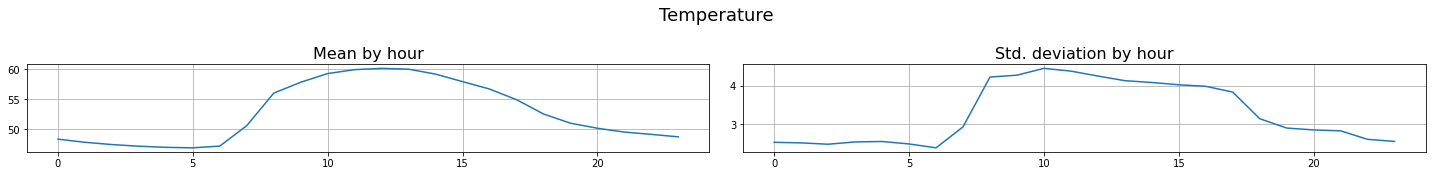

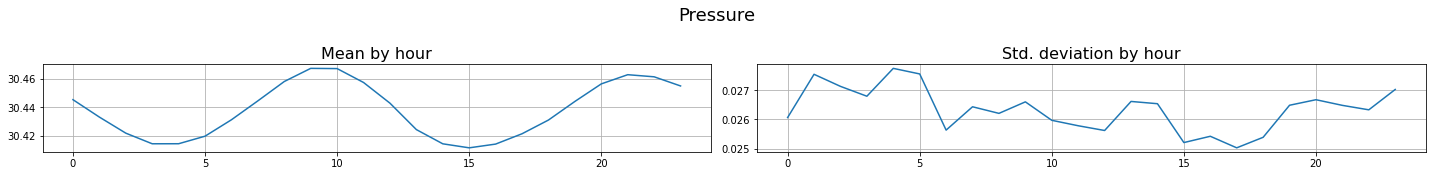

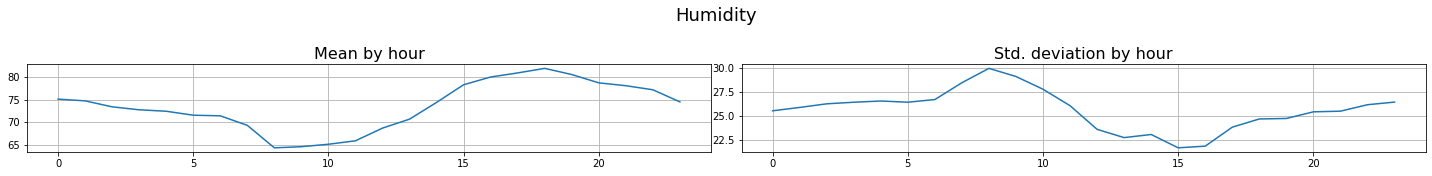

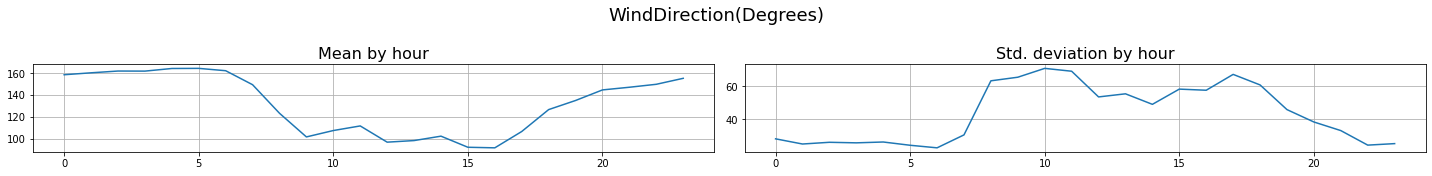

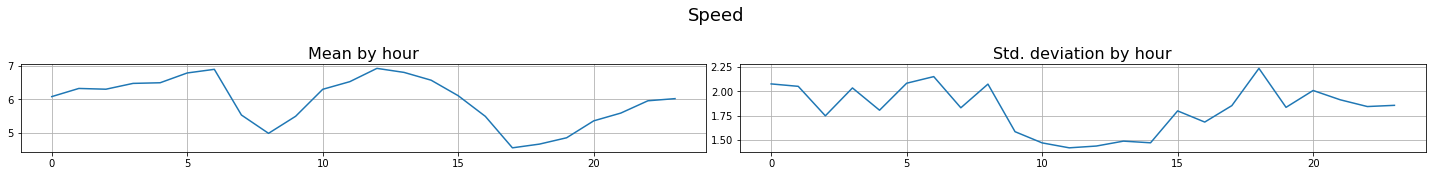

In [ ]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))
for J in range(6):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for hr in range(24):
    mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
  plt.rcParams["figure.figsize"]=[20,2]
  plt.suptitle(var_name,size=18,y=1.2)
  plt.subplot(1,2,1),plt.title("Mean by hour",size=16)
  plt.plot(mean_per_hr),plt.grid()
  plt.subplot(1,2,2),plt.title("Std. deviation by hour",size=16)
  plt.plot(std_per_hr),plt.grid()
  plt.tight_layout()
  plt.show()

### Respuesta
Podemos ver que la radiacion se presenta entre las 6 y 18 hrs y que la temperatura tiene un patron directamente proporcional a la radiacion, mientras que la humedad es inversamente proporcional a esta, por otro lado, los demas parametros no presentan una clara relación entre ellos.

##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Tienendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xy_tr_sc = scaler.fit_transform(data_tr)
xy_val_sc = scaler.fit_transform(data_val)
xy_tst_sc = scaler.fit_transform(data_tst)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [ ]:
len_inp=24
len_out=24
x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_tr)
x_tst,y_tst,t_tst=split_sequence(xy_tst_sc,len_inp,len_out,time_tr)

**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.

In [ ]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (378, 24, 6), (378, 24, 6), (1935, 24), (378, 24), (378, 24))

### Respuesta
X.shape: (cantidad de secuencias , largo de la secuencia , cantidad de parametros)

Y.shape: (cantidad de registros o secuencias, largo de la secuencia del parametro Radiacion)

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas. <br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**

### Respuesta
Las redes recurrentes nos ayudan a entrenar de manera tal que tomamos en cuenta el contexto temporal de los datos, lo que permite trabajar con series de tiempo tomando en cuenta la secuencialidad de la misma.

La red LSTM es un tipo de red Recurrente que busca solucionar el problema de gradiente explosivo y desvaneciente de la red recurrente clasica (Elman), mediante el uso de compuertas que permiter recordar y olvidar el informacion de tiempos anteriores segun sea mas conveniente. Tambien permite extender la capacidad de memoria de la red.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1 = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=15, batch_size=16,verbose=False)

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_2=models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2 = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=15, batch_size=16,verbose=False)

y_pred_1=model_1(x_tst[:,:,0:1])
tst_loss_1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()
y_pred_2=model_2(x_tst)
tst_loss_2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                14112     
________________________________________

In [ ]:
def plot_func(history, title, tst_loss):
  plt.title(title)
  plt.plot(history.history["loss"],"b-.",label="Train_loss")
  plt.plot(history.history["val_loss"],"g-.",label="Val_loss")
  plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Tst_loss")
  plt.xlabel("Epochs"),plt.ylabel("MSE Error")
  plt.legend(),plt.grid()

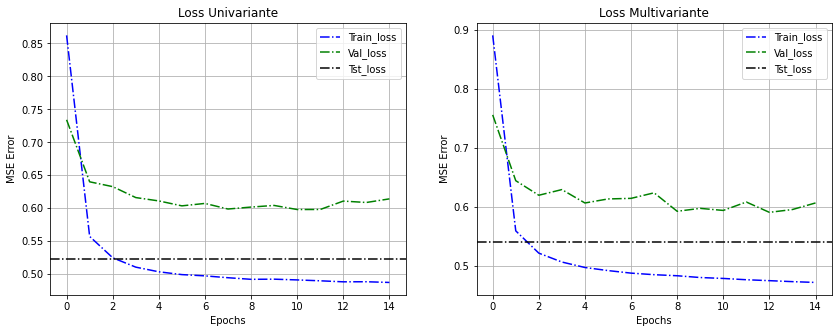

In [ ]:
from pylab import rcParams
plt.rcParams["figure.figsize"]=[14,5]
plt.subplot(1,2,1)
plot_func(history_1,"Loss Univariante",tst_loss_1)
plt.subplot(1,2,2)
plot_func(history_2,"Loss Multivariante",tst_loss_2)
plt.show()


### Comentario
Ambas redes tienen un desempeño similar, dando mejores resultados la red multivariante, aunque sin mejoras significativas.
Esto nos da a entender que gran parte de la prediccion depende unicamente de los datos de la variable Radiacion.

## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. **Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  **Comente**.

El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:** ¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

### Respuesta
La LSTM toma como entrada una secuencia de datos, y cuando esta tiene estado return_sequences = False, entregaria a la capa siguiente el output del último tiempo, en cambio, si es True, se retornaria un valor por cada tiempo de la red recurrente, dando como output otra secuencia. 

Con respecto al uso de return_sequences = False antes la capa densa, depende del caso, si se necesita una secuencia como output, puede ser mas util tener este parametro en True, mientras que seria falso en otros casos.

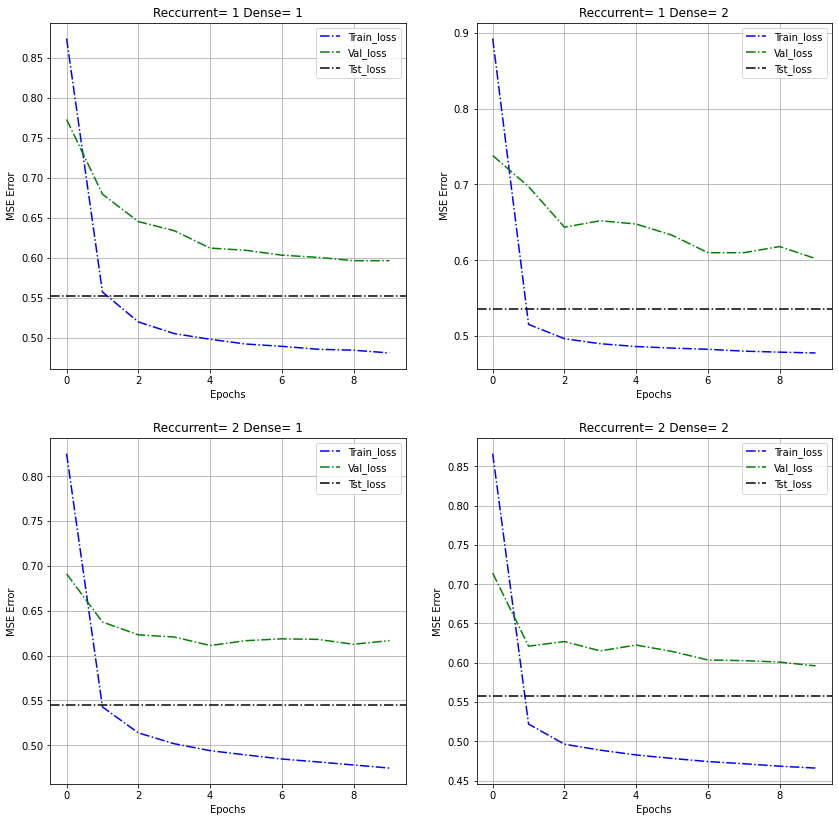

In [ ]:
minval = []
mintrain = []
labels=[]
plt.rcParams["figure.figsize"]=[14,14]
for recurrent in range(2):
  for dense in range(2):
    input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
    if recurrent==1:
      rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
      rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
    else:
      rnn=layers.LSTM(units=56,r(input_lstm) # 2° lstm
    if dense==1:eturn_sequences=False)
      dens=layers.Dense(32, activation='relu')(rnn) # 1° densa
      dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
    else:
      dens=layers.Dense(len_out, activation='sigmoid')(rnn) # 2° densa
    model=models.Model(inputs=input_lstm, outputs=dens)
    model.compile(loss='mse', optimizer='adam')
    # model.summary()
    history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
    y_pred=model(x_tst)
    tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()
    plt.subplot(2,2,2*recurrent+dense+1)
    for index,val in enumerate(history.history["val_loss"]):
      if val <= min:
        min=val
        ind=index
    minval.append(history.history["val_loss"][ind])
    mintrain.append(history.history["loss"][ind])
    labels.append("Reccurrent= "+str(recurrent+1) +" Dense= "+str(dense+1))
    plot_func(history, "Reccurrent= "+str(recurrent+1) +" Dense= "+str(dense+1) , tst_loss)
plt.show()

### Comentario
La red con 2 RNN y 2 Densas se asemeja en el val loss a la que tiene 1 RNN y 1 Densa teniendo ambas los mejores errores de validación, pero la primera sobreajusta en mayor medida, lo cual se puede atribuir a una mayor complejidad de la red.

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional? 

### Respuesta 
Da mejores resultado el uso de un reloj con estas caracteriticas, ya que al representar el tiempo de forma bidimensional con un ciclo de seno y coseno, podemos ver continuidad en la representacion del tiempo, a diferencia de usar tiempo unidimensional, donde por ejemplo, se pasa de 23:55 a 00:00 con una gran diferencia horaria, cuando en realidad son solo 5 minutos.

In [ ]:
daytimehrs=[6,18]

In [ ]:
from math import *
hour_1_tr=np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr=np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr=(1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)
hour_1_val=np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val=np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val=(1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)
hour_1_tst=np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst=np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst=(1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)

ext_tr=np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val=np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst=np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)

In [ ]:
from keras.layers import concatenate

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 1° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(len_out, activation='sigmoid')(input_dense) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=15, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 24, 56)       14112       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 56)           25312       lstm_8[0][0]                     
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

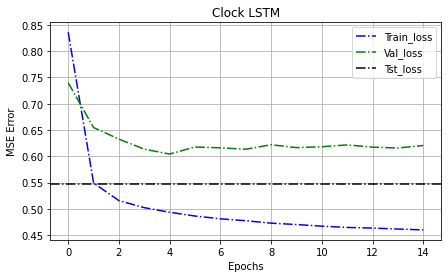

In [ ]:
plt.rcParams["figure.figsize"]=[7,4]
plot_func(history, "Clock LSTM", tst_loss)
val=10000
for index,val in enumerate(history.history["val_loss"]):
  if val <= min:
    min=val
    ind=index
minval.append(history.history["val_loss"][ind])
mintrain.append(history.history["loss"][ind])
labels.append("Clock LSTM")

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

### Respuesta 

LSTM tiene un hidden state que se actualiza a lo largo del tiempo y es el output de la red, y ademas tiene un cell state que se actualiza en cada tiempo, ponderando la informacion que debe olvidarse o mantenerse. La red LSTM cuenta con 3 compuertas:
- Compuerta de olvido: decide cuanta informacion del cell state debe olvidarse, tomando como input el hidden state, y el input del tiempo actual.
- Compuerta de input: decide cuanta informacion del input debe almacenarse/recordarse en el cell state, para esto se considera el hidden state, y el input del tiempo actual.
- Compuerta de output: indica cuanta informacion de la neurona actual es enviada a la siguiente, es decir, a partir del hidden state actual + input actual + cell state actualizado (habiendo olvidado y almacenado informacion en el estado actual), se calcula el hidden state que se enviará a la siguiente iteración de la RNN y/o a la siguiente capa.

En GRU la Update gate reemplaza la input y output gate de la LSTM y la reset gate decide cuanta informacion olvidar, esta es equivalente a la compuerta de olvido.

De esta forma, la arquitectura GRU es levemente más rápida por contar con una compuerta menos.


In [ ]:
input_gru= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.GRU(units=56,return_sequences=True)(input_gru) # 1° capa gru
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 1° capa gru
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(len_out, activation='sigmoid')(input_dense) # 2° densa
model=models.Model(inputs=[input_gru,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=15, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 24, 56)       10584       input_9[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 56)           18984       gru[0][0]                        
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 3)]          0                                            
____________________________________________________________________________________________

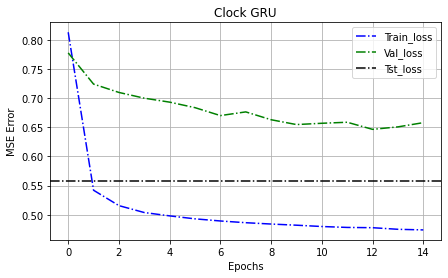

In [ ]:
plt.rcParams["figure.figsize"]=[7,4]
plot_func(history, "Clock GRU", tst_loss)
val=10000
for index,val in enumerate(history.history["val_loss"]):
  if val <= min:
    min=val
    ind=index
minval.append(history.history["val_loss"][ind])
mintrain.append(history.history["loss"][ind])
labels.append("Clock GRU")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 56)            10584     
_________________________________________________________________
gru_3 (GRU)                  (None, 56)                18984     
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1368      
Total params: 30,936
Trainable params: 30,936
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 9s 46ms/step - loss: 1.0100 - val_loss: 0.7690
Epoch 2/10
121/121 [==============================] - 5s 41ms/step - loss: 0.5662 - val_loss: 0.7224
Epoch 3/10
121/121 [==============================]

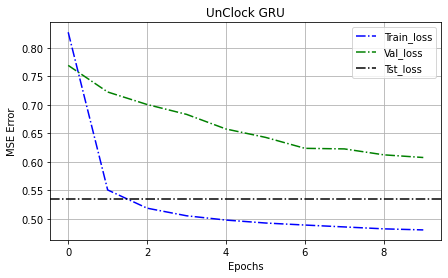

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(len_out, activation='sigmoid')(rnn) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model(x_tst)
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

plt.rcParams["figure.figsize"]=[7,4]
plot_func(history, "UnClock GRU", tst_loss)
val=10000
for index,val in enumerate(history.history["val_loss"]):
  if val <= min:
    min=val
    ind=index
minval.append(history.history["val_loss"][ind])
mintrain.append(history.history["loss"][ind])
labels.append("UnClock GRU")

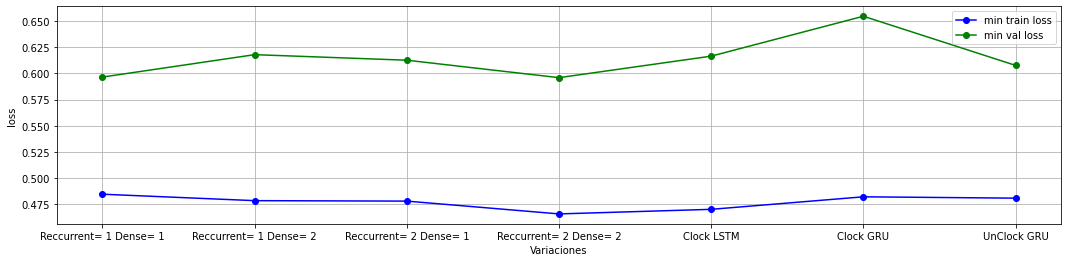

In [ ]:
plt.rcParams["figure.figsize"]=[18,4]
plt.plot(labels,mintrain,"-o",color="b",label="min train loss")
plt.plot(labels,minval,"-o",color="g",label="min val loss")
plt.xlabel("Variaciones")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(len_out, activation='sigmoid')(rnn) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16)


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 56)            14112     
_________________________________________________________________
lstm_11 (LSTM)               (None, 56)                25312     
_________________________________________________________________
dense_11 (Dense)             (None, 24)                1368      
Total params: 40,792
Trainable params: 40,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 11s 54ms/step - loss: 1.0336 - val_loss: 0.7038
Epoch 2/10
121/121 [==============================] - 6s 49ms/step - loss: 0.5574 - val_loss: 0.6404
Epoch 3/10
121/121 [==============================

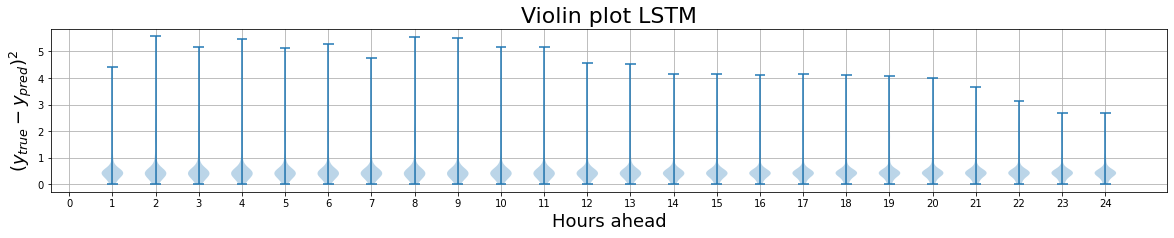

In [ ]:
y_pred=model(x_tst)
tst_loss=((y_tst - y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[20,3]
plt.title("Violin plot LSTM",size=22)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=18)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=18)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

### Respuesta
Violin plot es similar al boxplot, pero este además modela la distribución de los datos. En el caso graficado se ve que los errores son cercanos a cero.

## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. **Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una. 

ii) ¿Qué hace el método recurrent dropout?

### Respuesta proximamente
i) Existe el Grid search, que consiste basicamente en probar todas las posibles combinaciones entre los parametros, recorriendo un hipercubo que varía los parametros.

ii) El Drop out aplicado a las RNN es un metodo de regularizacion que se aplica a las compuertas de update y entrada, dada un probabilidad entregada como parametro.

In [ ]:
import random
from keras.regularizers import l1,l2
val_h=[]
def random_search():
  prof_rnn=np.random.randint(1,4)
  neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
  activator_rnn=[random.choice(['relu','sigmoid','tanh']) for t in range(prof_rnn)]
  initializer_rnn=random.choice(['he_uniform','glorot_normal','glorot_uniform'])
  rec_drop=np.random.uniform(0,0.5)
  prof_dens=np.random.randint(0,3)
  neu_dens=[np.random.randint(20,40) for t in range(prof_dens)]
  activator_dens=[random.choice(['relu','sigmoid','tanh']) for t in range(prof_dens)]
  initializer_dens=random.choice(['he_uniform','glorot_normal','glorot_uniform'])
  dens_drop=np.random.uniform(0,0.5)
  regu=random.choice([l1,l2,None])
  regu_lambda=np.random.rand()*0.3

  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  #Profundidad de la capa recurrente
  for i,neu in enumerate(neu_rnn):
    if i==0: 
      rnn=layers.LSTM(units=neu_rnn[0], activation=activator_rnn[i],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=initializer_rnn)(input_lstm)
    else: 
      rnn=layers.LSTM(units=56, activation=activator_rnn[i],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=initializer_rnn)(rnn)
  #Capas Densas 
  for i,neu in enumerate(neu_dens):
    if i==0:
      dens=layers.Dense(units=neu_dens[i], activation=activator_dens[i],kernel_initializer=initializer_dens,activity_regularizer= None if regu== None else regu(regu_lambda))(rnn)
    else:
      dens=layers.Dense(units=neu_dens[i], activation=activator_dens[i],kernel_initializer=initializer_dens,activity_regularizer= None if regu== None else regu(regu_lambda))(dens)
      dens=layers.Dropout(dens_drop)(dens)
  if prof_dens==0:
    dens=layers.Dense(len_out, activation='sigmoid',kernel_initializer=initializer_dens,activity_regularizer= None if regu== None else regu(regu_lambda))(rnn)
  else:
    dens=layers.Dense(len_out, activation='sigmoid',kernel_initializer=initializer_dens,activity_regularizer= None if regu== None else regu(regu_lambda))(dens)
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer='adam')
  return model, prof_rnn, neu_rnn,activator_rnn, initializer_rnn,rec_drop,prof_dens,neu_dens,activator_dens,initializer_dens,dens_drop,regu,regu_lambda



hyperparams=[]
for i in range(100):
  model, prof_rnn, neu_rnn,activator_rnn, initializer_rnn,rec_drop,prof_dens,neu_dens,activator_dens,initializer_dens,dens_drop,regu,regu_lambda = random_search()
  hyperparams.append((prof_rnn, neu_rnn,activator_rnn, initializer_rnn,rec_drop,prof_dens,neu_dens,activator_dens,initializer_dens,dens_drop,regu,regu_lambda))
  y_pred=model(x_val)
  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
  val_h.append(val_loss)
  print(i+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas: ", neu_rnn, " | Recurrent Activador: ", activator_rnn, " | Recurrent dropout: ", rec_drop)
  print("Profundidad dens: ",prof_dens, " | N° neuronas: ", neu_dens, " | Activadores: ", activator_dens, " | Dense dropout: ", dens_drop)
  print("Inicializador rnn: ",initializer_rnn, " | Inicializador dens: ",initializer_dens,  "| Regularizador: ", str(regu)[-4:-2], "| lambda: ", '-' if regu==None else regu_lambda )
  print("Validation error: ",val_loss)
  print("-"*120)

1 ° --->  Profundidad rnn:  1  | N° neuronas:  [36]  | Recurrent Activador:  ['relu']  | Recurrent dropout:  0.019713706158452304
Profundidad dens:  1  | N° neuronas:  [26]  | Activadores:  ['sigmoid']  | Dense dropout:  0.23474138817125434
Inicializador rnn:  glorot_normal  | Inicializador dens:  glorot_uniform | Regularizador:  L1 | lambda:  0.10844596155881678
Validation error:  1.2663424
------------------------------------------------------------------------------------------------------------------------
2 ° --->  Profundidad rnn:  2  | N° neuronas:  [34, 39]  | Recurrent Activador:  ['tanh', 'relu']  | Recurrent dropout:  0.4410718398207361
Profundidad dens:  1  | N° neuronas:  [26]  | Activadores:  ['sigmoid']  | Dense dropout:  0.4254475025849871
Inicializador rnn:  he_uniform  | Inicializador dens:  he_uniform | Regularizador:  L1 | lambda:  0.12737243218394503
Validation error:  1.2295489
---------------------------------------------------------------------------------------

1.2210075
(prof_rnn, neu_rnn, activator_rnn, initializer_rnn, rec_drop, prof_dens, neu_dens, activator_dens, initializer_dens, dens_drop, regu, regu_lambda)
(1, [21], ['sigmoid'], 'glorot_uniform', 0.23148314587467705, 0, [], [], 'glorot_uniform', 0.2269352671592702, None, 0.10426611672819926)


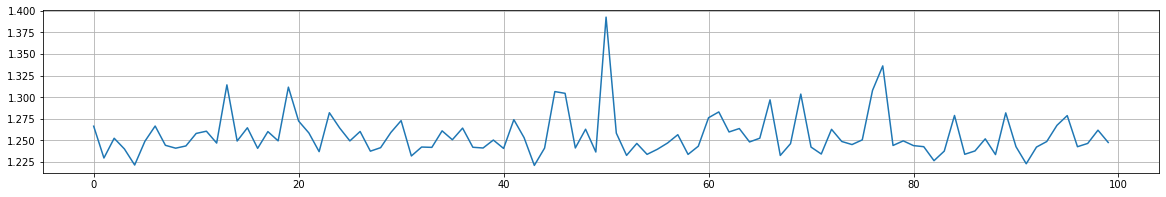

In [ ]:
plt.plot(val_h)
plt.grid()
print(np.min(val_h))
print("(prof_rnn, neu_rnn, activator_rnn, initializer_rnn, rec_drop, prof_dens, neu_dens, activator_dens, initializer_dens, dens_drop, regu, regu_lambda)")
print(hyperparams[val_h.index(np.min(val_h))])

La red con mejor Val loss fue:

Recurrente:
- Profundida: 1 
- Neuronas: 21
- Activador: Sigmoid
- Inicializador: glorot_uniform
- Dropout: 0.231

Densa:
- Profundidad capas ocultas: 0
- Neuronas capas ocultas: N.A (No Aplica)
- Activador: Sigmoid 
- Inicializador: glorot_uniform 
- Dropuot: 0.104 (No Aplica)
- Regularizador: None 
- Lambda Regularizador: N.A (No Aplica)

##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

### Respuesta
i) TimeSeriesSplit permite hacer un "k-folding" considerando la temporalidad de los datos, haciendo un split que asigna como tst_set los datos futuros del tr_set. Esto se hace para no validar el entrenamiento con datos del pasado.
En nuestro caso, este metodo es util dado que tenemos datos que tienen dependencia temporal y aportan al entrenamiento con contexto.

Ademas de este método de cross-validation, existen los métodos:
- k_folding: separa el data_set en k particiones y entrena con k-1 de ellas y testea con la restante variando en cada iteracion fold de testing.
- Repeated random sub-sampling validation: en cada iteracion elige de manera aleatoria un conjunto de training y otro de test.
- Leave-one-out cross-validation: Consta en separar un solo elemento del conjunto de entrenamiento para testear, y repetir el proceso. Esto quivaladría a realizar un k-folding con k = cantidad de datos del conjunto de train.

2) La idea de Cross Validation es garantizar la independencia de los paramentros encontrados de la particion realizada al entrenar y validar.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
data_tr_val, time_tr_val = data_hr[:int(data_hr.shape[0]*0.85)],time_hr[:int(data_hr.shape[0]*0.85)] # DIVIDE IN EACH FOLD
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):] # KEEP IT UNTIL THE END
# se debiese estandarizar en cada Fold ajustando el scaler con la data de entrenamiento que se genere

In [ ]:
tscv = TimeSeriesSplit()
data_tr_val_sc=scaler.fit_transform(data_tr_val) ##datos escalados estandar
cross_val_loss=[]
hyperparams=[]

for i in range(20):
  loss=[]
  model, prof_rnn, neu_rnn,activator_rnn, initializer_rnn,rec_drop,prof_dens,neu_dens,activator_dens,initializer_dens,dens_drop,regu,regu_lambda = random_search()
  hyperparams.append((prof_rnn, neu_rnn,activator_rnn, initializer_rnn,rec_drop,prof_dens,neu_dens,activator_dens,initializer_dens,dens_drop,regu,regu_lambda))
  
  for train_index, val_index in tscv.split(data_tr_val):
    data_tr, time_tr = data_tr_val_sc[train_index], time_tr_val[train_index]
    data_val, time_val = data_tr_val_sc[val_index], time_tr_val[val_index]
    x_tr,y_tr,t_tr=split_sequence(data_tr,len_inp,len_out,time_tr) ## Separar la columna de radiacion del dataset
    x_val,y_val,t_val=split_sequence(data_val,len_inp,len_out,time_val)
    y_pred=model(x_val)
    val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
    loss.append(val_loss)
  
  cross_val_loss.append(np.mean(loss))

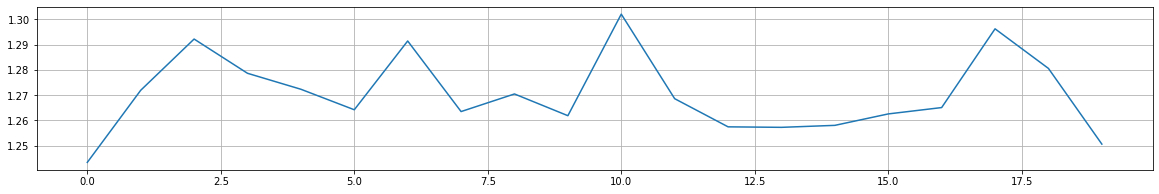

(3, [21, 29, 38], ['sigmoid', 'relu', 'tanh'], 'glorot_normal', 0.18683074871627164, 1, [21], ['sigmoid'], 'glorot_uniform', 0.11239918275614236, <class 'tensorflow.python.keras.regularizers.L2'>, 0.07444303678259678)


In [ ]:
plt.plot(cross_val_loss)
plt.grid()
plt.show()
print(hyperparams[cross_val_loss.index(np.min(cross_val_loss))])

# 2. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


## 2.a Carga de datos y preprocesamientos


##### I) Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**


### Respuesta
Porque lemma puede representar distintas palabras que son equivalentes pero escritas de manera diferente, esto hace la representacion mas facil y estable.

In [ ]:
username="gmezap"
key="67c43875aa87b82a44e920689eb419c7"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

 91% 24.0M/26.4M [00:01<00:00, 8.82MB/s]
100% 26.4M/26.4M [00:01<00:00, 23.8MB/s]
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
dataset.head(10)

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
5,through,O,through,1.0
6,london,B-geo,London,1.0
7,to,O,to,1.0
8,protest,O,protest,1.0
9,the,O,the,1.0


##### II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un metodo solo usando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante.

**Explique qué realiza cada linea del código.**

In [ ]:
# enumera cada palabra diferente almacenando el indice de esta en un diccionario
lemma_to_code = {lemma:code+1 for code, lemma in enumerate(dataset.lemma.unique())}   
# enumera cada tag diferente
tag_to_code = {tag:code+1 for code, tag in enumerate(dataset.tag.unique())}
# la cantidad de lemas diferentes
n_lemmas = len(lemma_to_code) 

# Reemplazamos los datos tipo string por los indices de cada lemma o tag
dataset['lemma'] = dataset.lemma.apply(lambda x: lemma_to_code[x])
dataset['tag'] = dataset.tag.apply(lambda x: tag_to_code[x])

# agrupa en secuencias los lemmas y tags de cada sentence_idx 
dff = dataset.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray)

In [ ]:
# Encuentra la secuencia mas larga y mas corta y muestra su posicion y tamaño
max=0
min=99999
for index, lemma in enumerate(dff["lemma"]):
  if len(lemma)>max:
    max=len(lemma)
    maxindex=index
  if len(lemma)<min:
    min=len(lemma)
    minindex=index
print(max,maxindex,min,minindex)

140 2548 1 26134


29.871620661227507 45.459535606158056 61.04745055108861 76.63536549601916 140


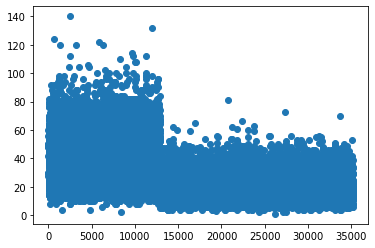

In [ ]:
# mostrar la distribucion del largo de las secuencias.
A=np.zeros(dff.shape[0])
for index, lemma in enumerate(dff["lemma"]):
  A[index]=len(lemma)
plt.scatter(range(len(A)),A)
print(A.mean(),A.mean()+A.std(),A.mean()+2*A.std(),A.mean()+3*A.std(),max)

## 2.b) Distribuciones.

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden qué problemas podría traer? ¿Están las clases repartidas de manera equitativa?

Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** (https://es.wikipedia.org/wiki/Ley_de_Zipf). Realice un gráfico de la cantidad de datos por clase. Comente.

##Respuesta pendiente
Según el gráfico, si se aprecia la ley de Zipf en la distribución de la frecuencia de las palabras.`

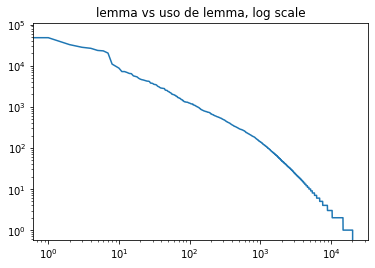

In [ ]:
Dist=np.zeros((20244))
for lemma in dataset["lemma"]:
  Dist[lemma]+=1
Dist=np.sort(Dist)[::-1]
plt.title('lemma vs uso de lemma, log scale')
plt.plot(Dist)
plt.yscale('log')
plt.xscale('log')
plt.show()

## 2.c) Padding y one hot vectors


##### I) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función keras.preprocessing.sequence.pad_sequences o escribir sus propios códigos. Elija un valor de maxlen que le parezca adecuado.

¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

### Respuesta
Se elige el padding despues de la frase porque en el lenguaje que trabajamos, se lee de izquierda a derecha, la clasificacion del padding como 0 es medianamente relevante, mientras que el codigo asignado sea diferente al de las tags no significaria un problema.


In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_len=80

X=pad_sequences(dff['lemma'], maxlen=max_len, padding='post',truncating='post')
y_no_categorical=pad_sequences(dff['tag'], maxlen=max_len, padding='post',truncating='post')
n_tags=np.max(y_no_categorical)+1

##### II) Para poder entregar una clasificación sobre los distintos *tags* es necesario transformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)


In [ ]:
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 80), (26382, 80, 18), (8795, 80), (8795, 80, 18))

### Respuesta
Las dimensiones de entrada son (la cantidad de secuencias, el largo de la secuencuencia), mientras que la de salida es (la cantidad de secuencias, el largo de cada la secuencia, el tag que representa cada dato de la secuencia).

## 2.d) RNN many to many



##### I) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.


### Comentario 
Los datos al ingresar a la red cambian su representación de 80 lemas, a un vector de largo 32, siendo 32 la dimensión del embedding.

Los parámetros de la red cambian en función del output del Embedding. 
- Parametros Embedding ((cantidad lemmas + 1)* embedding size) = (20.243 + 1) * 32 = 647.808
- Parametros LSTM: 4((embedding + 1)* out_lstm + out_lstm^2) = 4*((32+1)*128+128^2) = 82.432
- Parametros Densas (out_lstm + bias) * out_dense = (128+1)*18 = 2322

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

In [ ]:
#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m32 = Sequential()
embedding_dim = 32
m32.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len))
m32.add(LSTM(units=128,return_sequences=True))
m32.add(Dense(n_tags, activation='softmax'))
m32.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
m32.summary()
history32 = m32.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 32)            647808    
_________________________________________________________________
lstm_344 (LSTM)              (None, 80, 128)           82432     
_________________________________________________________________
dense_311 (Dense)            (None, 80, 18)            2322      
Total params: 732,562
Trainable params: 732,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 59s 275ms/step - loss: 1.1133 - acc: 0.7564 - val_loss: 0.3023 - val_acc: 0.9429
Epoch 2/3
207/207 [==============================] - 57s 275ms/step - loss: 0.2761 - acc: 0.9420 - val_loss: 0.1739 - val_acc: 0.9518
Epoch 3/3
207/207 [==============================] - 57s 277ms/step - loss: 0.1582 - acc: 0.9543 - val_loss: 0.1

Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases.

In [ ]:
from sklearn.metrics import classification_report 

In [ ]:
y_pred=m32(x_val).numpy().reshape(y_val.shape[0]*y_val.shape[1],y_val.shape[2])
y_pred = (y_pred > 0.5) 
y_val_reshaped=y_val.reshape(y_val.shape[0]*y_val.shape[1],y_val.shape[2])
print(classification_report(y_val_reshaped, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443370
           1       0.97      0.98      0.98    220644
           2       0.77      0.45      0.57      9361
           3       0.00      0.00      0.00      4137
           4       1.00      0.00      0.01      4052
           5       0.00      0.00      0.00      1822
           6       0.00      0.00      0.00      5017
           7       0.00      0.00      0.00      4103
           8       0.96      0.32      0.47      4995
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.86      0.37      0.52      4127
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1490
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        95
          16       0.00      0.00      0.00        83
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### II) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [ ]:
#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m16 = Sequential()
embedding_dim = 16
m16.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len))
m16.add(LSTM(units=128,return_sequences=True))
m16.add(Dense(n_tags, activation='softmax'))
m16.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
m16.summary()
history16 = m16.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 16)            323904    
_________________________________________________________________
lstm_345 (LSTM)              (None, 80, 128)           74240     
_________________________________________________________________
dense_312 (Dense)            (None, 80, 18)            2322      
Total params: 400,466
Trainable params: 400,466
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 57s 266ms/step - loss: 1.2229 - acc: 0.7187 - val_loss: 0.3371 - val_acc: 0.9398
Epoch 2/3
207/207 [==============================] - 54s 263ms/step - loss: 0.3190 - acc: 0.9409 - val_loss: 0.2330 - val_acc: 0.9427
Epoch 3/3
207/207 [==============================] - 54s 259ms/step - loss: 0.2038 - acc: 0.9451 - val_loss: 0

In [ ]:
y_pred=m16(x_val).numpy().reshape(y_val.shape[0]*y_val.shape[1],y_val.shape[2])
y_pred = (y_pred > 0.5) 
y_val_reshaped=y_val.reshape(y_val.shape[0]*y_val.shape[1],y_val.shape[2])
print(classification_report(y_val_reshaped, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443370
           1       0.97      0.98      0.97    220644
           2       0.91      0.03      0.05      9361
           3       0.00      0.00      0.00      4137
           4       0.00      0.00      0.00      4052
           5       0.00      0.00      0.00      1822
           6       0.00      0.00      0.00      5017
           7       0.00      0.00      0.00      4103
           8       0.00      0.00      0.00      4995
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.90      0.13      0.22      4127
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1490
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        95
          16       0.00      0.00      0.00        83
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


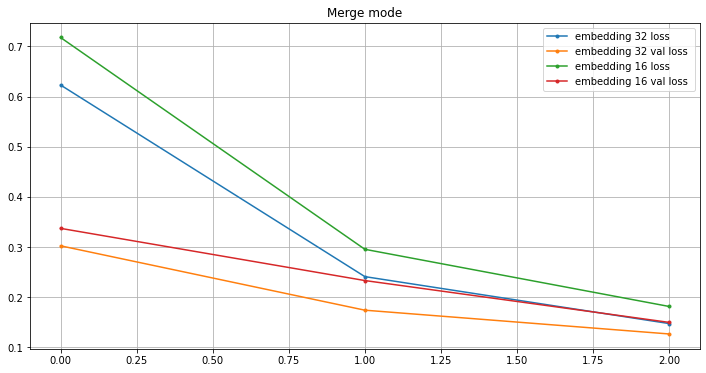

In [ ]:
plt.rcParams["figure.figsize"]=[12,6]
plt.plot(history32.history['loss'],'.-',label= 'embedding 32 loss ')
plt.plot(history32.history['val_loss'],'.-',label= 'embedding 32 val loss ')
plt.plot(history16.history['loss'],'.-',label= 'embedding 16 loss ')
plt.plot(history16.history['val_loss'],'.-',label= 'embedding 16 val loss ')
plt.title('Merge mode')
plt.grid()
plt.legend()
plt.show()

### Comentario 
Usando un embedding mas grande, el valor del acuraccy y la val_loss disminuyen levemente.

## 2.e) RNN Bidireccional y masking


##### I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

In [ ]:
from keras.layers import Bidirectional, Embedding

In [ ]:
for merge in ['sum', 'mul', 'concat', 'ave']:
  print(merge)
  model = Sequential()
  model.add(Embedding(input_dim=18, output_dim=32, input_length=140))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode=merge))
  model.add(Dense(18, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  # history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2 )
  model.summary()

sum
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 32)           576       
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 100)          106400    
_________________________________________________________________
dense_90 (Dense)             (None, 140, 18)           1818      
Total params: 108,794
Trainable params: 108,794
Non-trainable params: 0
_________________________________________________________________
mul
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 32)           576       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 100)          106400    
________________

In [ ]:
val_lo ss=[]
loss=[]
for merge in ['sum', 'mul', 'concat', 'ave']:
  print(merge)
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=max_len))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode=merge))
  model.add(Dense(18, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2 )
  val_loss.append(history.history['val_loss'])
  loss.append(history.history['loss'])

sum
Epoch 1/3
207/207 - 71s - loss: 0.4974 - acc: 0.8929 - val_loss: 0.2389 - val_acc: 0.9434
Epoch 2/3
207/207 - 67s - loss: 0.1765 - acc: 0.9505 - val_loss: 0.1407 - val_acc: 0.9584
Epoch 3/3
207/207 - 67s - loss: 0.1171 - acc: 0.9670 - val_loss: 0.0982 - val_acc: 0.9743
mul
Epoch 1/3
207/207 - 76s - loss: 0.7591 - acc: 0.8583 - val_loss: 0.3099 - val_acc: 0.9437
Epoch 2/3
207/207 - 71s - loss: 0.2375 - acc: 0.9446 - val_loss: 0.1630 - val_acc: 0.9538
Epoch 3/3
207/207 - 72s - loss: 0.1305 - acc: 0.9642 - val_loss: 0.1064 - val_acc: 0.9730
concat
Epoch 1/3
207/207 - 80s - loss: 0.5115 - acc: 0.8877 - val_loss: 0.2872 - val_acc: 0.9421
Epoch 2/3
207/207 - 75s - loss: 0.2574 - acc: 0.9425 - val_loss: 0.1854 - val_acc: 0.9487
Epoch 3/3
207/207 - 75s - loss: 0.1441 - acc: 0.9581 - val_loss: 0.1199 - val_acc: 0.9641
ave
Epoch 1/3
207/207 - 76s - loss: 0.5668 - acc: 0.8771 - val_loss: 0.2973 - val_acc: 0.9425
Epoch 2/3
207/207 - 72s - loss: 0.2826 - acc: 0.9423 - val_loss: 0.2435 - val_acc

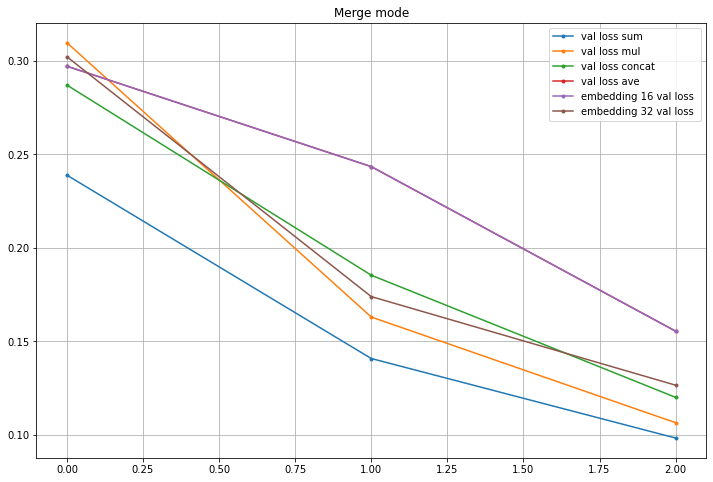

In [ ]:
plt.rcParams["figure.figsize"]=[12,8]
for i,title in enumerate(['sum', 'mul', 'concat', 'ave']):
  # plt.plot(loss[i],'.-',label= 'loss '+title)
  plt.plot(val_loss[i],'.-',label= 'val loss '+title)
  
# plt.plot(history.history['loss'],'.-',label= 'embedding 16 loss ')
plt.plot(history.history['val_loss'],'.-',label= 'embedding 16 val loss ')
# plt.plot(history32.history['loss'],'.-',label= 'embedding 32 loss ')
plt.plot(history32.history['val_loss'],'.-',label= 'embedding 32 val loss ')
plt.title('Merge mode')
plt.grid()
plt.legend()
plt.show()

### Comentario
Vemos una clara mejora usando redes bidireccionales, siendo la suma el mejor metodo de union.
Consideramos que la forma correcta de usar el merge mode es aquella que de mejores resultado, ya sea en accuracy, o val loss.  

El uso de la concatenación duplica el tamaño de la secuencia de salida y otorga una doble interpretacion de la secuencia que es reconocido por las capas densas, a diferencia de los merge con suma, multiplicacion o promedio que aportan "ruido" a la salida pues se combinan ambas salidas manteniendo el largo de entrada.

##### II) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. Entrene la red definida en 2.d.I) y compare al utilizar esta funcionalidad de enmascarar el valor 0  en este caso para el default de la capa embedding.


### Mask Zeros

ave
Epoch 1/3
207/207 [==============================] - 100s 448ms/step - loss: 0.4622 - acc: 0.8232 - val_loss: 0.1553 - val_acc: 0.8764
Epoch 2/3
207/207 [==============================] - 90s 434ms/step - loss: 0.1400 - acc: 0.8895 - val_loss: 0.1001 - val_acc: 0.9276
Epoch 3/3
207/207 [==============================] - 90s 433ms/step - loss: 0.0866 - acc: 0.9364 - val_loss: 0.0748 - val_acc: 0.9437
ave
Epoch 1/3
207/207 [==============================] - 82s 381ms/step - loss: 0.9621 - acc: 0.8005 - val_loss: 0.2561 - val_acc: 0.9435
Epoch 2/3
207/207 [==============================] - 77s 370ms/step - loss: 0.2195 - acc: 0.9452 - val_loss: 0.1477 - val_acc: 0.9567
Epoch 3/3
207/207 [==============================] - 76s 368ms/step - loss: 0.1374 - acc: 0.9594 - val_loss: 0.1112 - val_acc: 0.9713


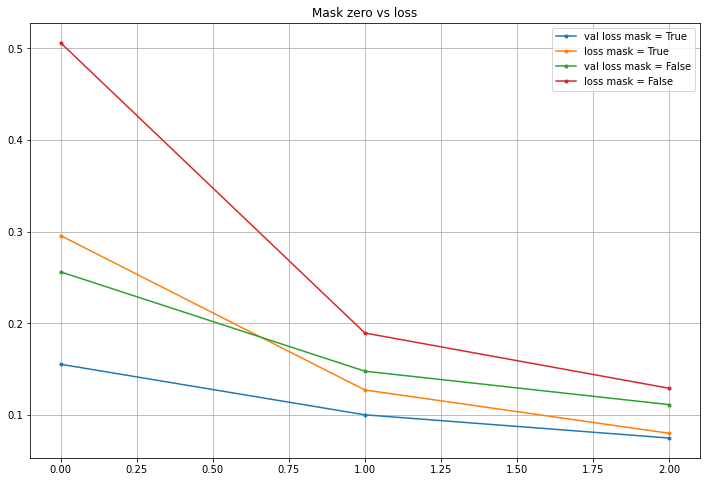

In [ ]:
for boolean in [True, False]:
  print(boolean)
  model = Sequential()
  embedding_dim = 32
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len, mask_zero=boolean))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode='sum'))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=1)
  plt.plot(history.history['val_loss'],'.-',label= 'val loss mask = '+str(boolean))
  plt.plot(history.history['loss'],'.-',label= 'loss mask = '+str(boolean))
plt.title('Mask zero vs loss')
plt.grid()
plt.legend()
plt.show()

### Comentario
El masking mejora el error de validación.

## 2.f) Mejora libre

En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

### Max len

In [ ]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, GRU

45
Epoch 1/3
207/207 - 57s - loss: 0.4975 - acc: 0.8459 - val_loss: 0.2607 - val_acc: 0.8743
Epoch 2/3
207/207 - 47s - loss: 0.2205 - acc: 0.8926 - val_loss: 0.1856 - val_acc: 0.9195
Epoch 3/3
207/207 - 47s - loss: 0.1472 - acc: 0.9358 - val_loss: 0.1318 - val_acc: 0.9420
61
Epoch 1/3
207/207 - 72s - loss: 0.3805 - acc: 0.8480 - val_loss: 0.2013 - val_acc: 0.8743
Epoch 2/3
207/207 - 62s - loss: 0.1698 - acc: 0.8958 - val_loss: 0.1378 - val_acc: 0.9202
Epoch 3/3
207/207 - 62s - loss: 0.1099 - acc: 0.9378 - val_loss: 0.0995 - val_acc: 0.9412
76
Epoch 1/3
207/207 - 88s - loss: 0.3116 - acc: 0.8480 - val_loss: 0.1620 - val_acc: 0.8784
Epoch 2/3
207/207 - 77s - loss: 0.1341 - acc: 0.9003 - val_loss: 0.1080 - val_acc: 0.9261
Epoch 3/3
207/207 - 77s - loss: 0.0849 - acc: 0.9410 - val_loss: 0.0781 - val_acc: 0.9445
140
Epoch 1/3
207/207 - 151s - loss: 0.1712 - acc: 0.8473 - val_loss: 0.0895 - val_acc: 0.8746
Epoch 2/3
207/207 - 140s - loss: 0.0734 - acc: 0.8997 - val_loss: 0.0576 - val_acc: 0.

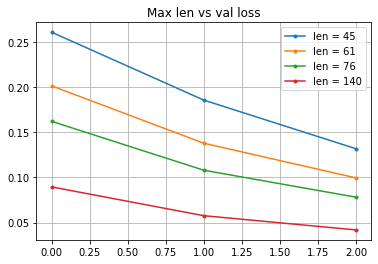

In [ ]:
max_len=[A.mean()+A.std(),A.mean()+2*A.std(),A.mean()+3*A.std(),np.max(A)]
for len in max_len:
  print(str(int(len)))
  X=pad_sequences(dff['lemma'], maxlen=int(len), padding='post',truncating='post')
  y_no_categorical=pad_sequences(dff['tag'], maxlen=int(len), padding='post',truncating='post')
  n_tags=np.max(y_no_categorical)+1
  y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
  x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

  model = Sequential()
  embedding_dim = 32
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=int(len), mask_zero=True))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode='sum'))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2)
  plt.plot(history.history['val_loss'],'.-',label= 'len = '+str(int(len)))

plt.title('Max len vs val loss')
plt.grid()
plt.legend()
plt.show()


### Pre post LSTM

Epoch 1/3
207/207 - 275s - loss: 0.1770 - acc: 0.8436 - val_loss: 0.1027 - val_acc: 0.8594
Epoch 2/3
207/207 - 268s - loss: 0.0773 - acc: 0.8919 - val_loss: 0.0642 - val_acc: 0.9133
Epoch 3/3
207/207 - 273s - loss: 0.0562 - acc: 0.9268 - val_loss: 0.0548 - val_acc: 0.9282
Epoch 1/3
207/207 - 257s - loss: 0.1835 - acc: 0.8426 - val_loss: 0.1554 - val_acc: 0.8479
Epoch 2/3
207/207 - 247s - loss: 0.1003 - acc: 0.8711 - val_loss: 0.0708 - val_acc: 0.8969
Epoch 3/3
207/207 - 247s - loss: 0.0616 - acc: 0.9113 - val_loss: 0.0577 - val_acc: 0.9194
Epoch 1/3
207/207 - 158s - loss: 0.1699 - acc: 0.8476 - val_loss: 0.0900 - val_acc: 0.8753
Epoch 2/3
207/207 - 146s - loss: 0.0755 - acc: 0.8941 - val_loss: 0.0613 - val_acc: 0.9228
Epoch 3/3
207/207 - 146s - loss: 0.0483 - acc: 0.9375 - val_loss: 0.0437 - val_acc: 0.9425
Epoch 1/3
207/207 - 391s - loss: 0.1804 - acc: 0.8428 - val_loss: 0.1572 - val_acc: 0.8479
Epoch 2/3
207/207 - 372s - loss: 0.1483 - acc: 0.8482 - val_loss: 0.0935 - val_acc: 0.8697

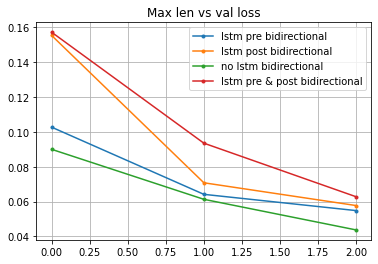

In [ ]:
X=pad_sequences(dff['lemma'], maxlen=140, padding='post',truncating='post')
y_no_categorical=pad_sequences(dff['tag'], maxlen=140, padding='post',truncating='post')
n_tags=np.max(y_no_categorical)+1
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
labels=['lstm pre bidirectional','lstm post bidirectional','no lstm bidirectional','lstm pre & post bidirectional']
for i in range(4):
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=140, mask_zero=True))
  if i == 0 or i == 3:
    model.add(LSTM(units=100, return_sequences=True))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode='sum'))
  if i== 1 or i ==3:
    model.add(LSTM(units=100, return_sequences=True))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2)
  plt.plot(history.history['val_loss'],'.-',label= labels[i])

plt.title('Max len vs val loss')
plt.grid()
plt.legend()
plt.show()


### Densas

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 140, 32)           647808    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 140, 100)          106400    
_________________________________________________________________
dense_19 (Dense)             (None, 140, 18)           1818      
Total params: 756,026
Trainable params: 756,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 - 152s - loss: 0.1733 - acc: 0.8471 - val_loss: 0.0880 - val_acc: 0.8777
Epoch 2/3
207/207 - 140s - loss: 0.0725 - acc: 0.9045 - val_loss: 0.0596 - val_acc: 0.9243
Epoch 3/3
207/207 - 140s - loss: 0.0481 - acc: 0.9385 - val_loss: 0.0431 - val_acc: 0.9434
Model: "sequential_17"
_________________________________________________________________
Layer (type)   

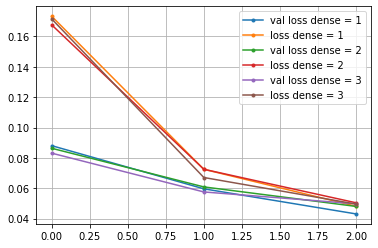

In [ ]:
X=pad_sequences(dff['lemma'], maxlen=140, padding='post',truncating='post')
y_no_categorical=pad_sequences(dff['tag'], maxlen=140, padding='post',truncating='post')
n_tags=np.max(y_no_categorical)+1
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
for i in range(3):
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=140, mask_zero=True))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode='sum'))
  for j in range(i):
    model.add(Dense(80, activation='relu'))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  model.summary()
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2)
  plt.plot(history.history['val_loss'],'.-',label= 'val loss dense = '+str(i+1))
  plt.plot(history.history['loss'],'.-',label= 'loss dense = '+str(i+1))

plt.grid()
plt.legend()
plt.show()


### Gru vs LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 32)           647808    
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 100)          106400    
_________________________________________________________________
dense (Dense)                (None, 140, 18)           1818      
Total params: 756,026
Trainable params: 756,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 - 148s - loss: 0.1709 - acc: 0.8481 - val_loss: 0.0889 - val_acc: 0.8779
Epoch 2/3
207/207 - 138s - loss: 0.0723 - acc: 0.9021 - val_loss: 0.0591 - val_acc: 0.9250
Epoch 3/3
207/207 - 138s - loss: 0.0466 - acc: 0.9405 - val_loss: 0.0429 - val_acc: 0.9442
Model: "sequential_1"
_________________________________________________________________
Layer (type)       

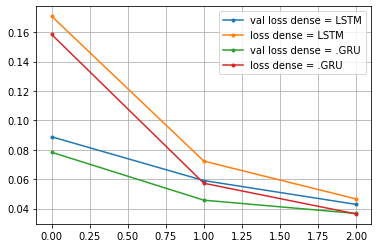

In [ ]:
X=pad_sequences(dff['lemma'], maxlen=140, padding='post',truncating='post')
y_no_categorical=pad_sequences(dff['tag'], maxlen=140, padding='post',truncating='post')
n_tags=np.max(y_no_categorical)+1
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

for rnn in [LSTM, GRU]:
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=140, mask_zero=True))
  layer_rnn = rnn(units=100,return_sequences=True)
  model.add(Bidirectional(layer_rnn,merge_mode='sum'))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  model.summary()
  history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128, verbose=2)
  plt.plot(history.history['val_loss'],'.-',label= 'val loss dense = '+str(rnn)[-6:-2])
  plt.plot(history.history['loss'],'.-',label= 'loss dense = '+str(rnn)[-6:-2])

plt.grid()
plt.legend()
plt.show()

### Mejor combinación

- Embedding: 32
- Largo de la secuencia: 140
- Mask zeros: True
- Sin capas rnn antes o despues de la Bidireccional
- Bidireccional layer: GRU 100 neuronas
- Bidireccional merge: sum
- Una sola capa densa de salida

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 32)           647808    
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 100)          80400     
_________________________________________________________________
dense (Dense)                (None, 140, 18)           1818      
Total params: 730,026
Trainable params: 730,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
207/207 - 124s - loss: 0.1599 - acc: 0.8537 - val_loss: 0.0797 - val_acc: 0.8988
Epoch 2/4
207/207 - 112s - loss: 0.0590 - acc: 0.9256 - val_loss: 0.0473 - val_acc: 0.9393
Epoch 3/4
207/207 - 111s - loss: 0.0380 - acc: 0.9500 - val_loss: 0.0375 - val_acc: 0.9493
Epoch 4/4
207/207 - 113s - loss: 0.0293 - acc: 0.9597 - val_loss: 0.0343 - val_acc: 0.9523


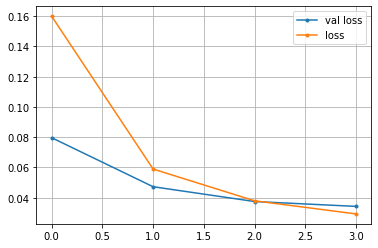

In [ ]:
X=pad_sequences(dff['lemma'], maxlen=140, padding='post',truncating='post')
y_no_categorical=pad_sequences(dff['tag'], maxlen=140, padding='post',truncating='post')
n_tags=np.max(y_no_categorical)+1
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in y_no_categorical])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=140, mask_zero=True))
layer_rnn=GRU(units=100,return_sequences=True)
model.add(Bidirectional(layer_rnn,merge_mode='sum'))
model.add(Dense(n_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
model.summary()
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=4, batch_size=128, verbose=2)
plt.plot(history.history['val_loss'],'.-',label= 'val loss')
plt.plot(history.history['loss'],'.-',label= 'loss')

plt.grid()
plt.legend()
plt.show()

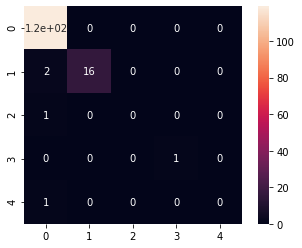

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from random import randint

rand=randint(0,y_val.shape[0])

y_pred=model.predict(x_val[rand]).reshape((140,18))
y_pred = (y_pred > 0.5) 

sns.heatmap(confusion_matrix(y_val[rand].argmax(axis=1), y_pred.argmax(axis=1)),annot=True,square=True)


In [ ]:
for i in[True, False]:
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas+1, output_dim=32, input_length=140, mask_zero=True))
  model.add(GRU(units=100,return_sequences=i))
  model.add(Dense(n_tags, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
  model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 140, 32)           647808    
_________________________________________________________________
gru_13 (GRU)                 (None, 140, 100)          40200     
_________________________________________________________________
dense_14 (Dense)             (None, 140, 18)           1818      
Total params: 689,826
Trainable params: 689,826
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 140, 32)           647808    
_________________________________________________________________
gru_14 (GRU)                 (None, 100)               40200     
________________________

## 2.g) Escribamos palabras


##### I) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado.

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia.

En este item debe cargar el dataset. **Explique lo que hace el código entregado**

In [ ]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

# concatenamos todas las columnas del dataset 
df_w = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)
# quitamos los missing values de la columna word 
df_w = df_w.dropna()[['word']]

# Concatenamos todas las palabras en un texto 
corpus = ' '.join(list(df_w.word.values)).lower()
#definimos el largo de la sentencia y cada cuantos pasos se avanza
sentence_length = 40
steps = 5

sentences = []
next_char = []
# cada 5 caracteres agregamos sentencias de largo 40 y el caracte siguiente a la misma 
for i in range(0,len(corpus) - sentence_length - 1 , steps):
  sentences.append(corpus[i:sentence_length+i])
  next_char.append(corpus[sentence_length+i])

# enumeramos los caracteres 
chars_to_code = {char:code for code, char in enumerate(set(corpus))}
code_to_chars = {code:char for char,code in chars_to_code.items()}

# generamos las sentencias con sus caracteres enumerado en vez de letras
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])
y = np.array([chars_to_code[char] for char in next_char])
y = to_categorical(y) 

Skipping line 281837: Expected 25 fields in line 281837, saw 34


##### II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas.

Una vez esté satisfecho de su red, hágala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys

def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=False))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character.fit(x,y, epochs=1, batch_size = 512,callbacks=[print_text_callback])
character.summary()

2371/2371 [==============================] - 865s 364ms/step - loss: 1.8462 - acc: 0.4598

 Generating random text for epoch: 0

 Generating with seed: g troops and cease-fire monitors . the f
g troops and cease-fire monitors . the forces at partors of safencizatiated take in kornalsration alexteresting apshaticul died at monday akords occate extensurated safgha mility of at added trade dolest augibens alsoul ( colows chavo , colowed at least the said more . the spscheamerstorly hus molousth all and bettopp nili areations for a villed coolated aprosicmed thousial bettelemontardy . relicled to mainy at whues counclishs in the Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
______________

### Respuesta
La prediccion seria claramente diferentes, con otro tipo de frases o conjugaciones, pudiendo variar el largo de las palabras, entre otras cosas.
Respecto a los resultados, estos carecen de coherencia, aunque en algunos momentos, se puede apreciar la formación de algunas palabras.

# 3. Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imágenes de articulos de vestimenta, el Fashion MNIST. 

## 3.a) Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

In [ ]:
from keras.datasets import fashion_mnist
(x_tr,y_tr),(x_val,y_val) = fashion_mnist.load_data()

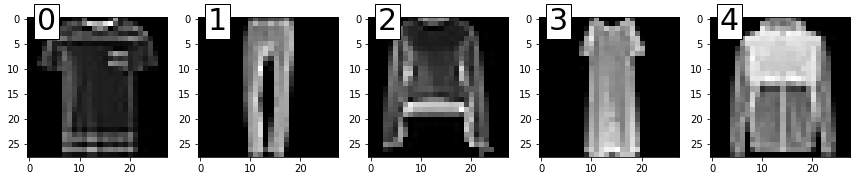

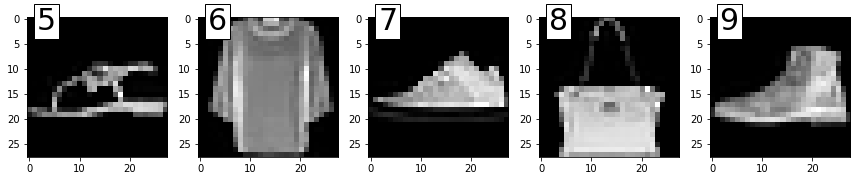

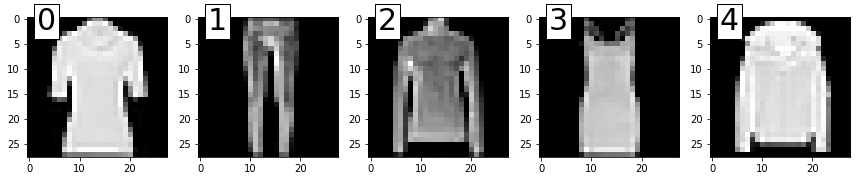

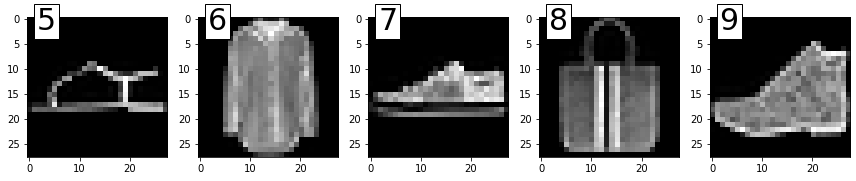

In [ ]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np 

plt.rcParams["figure.figsize"]=[12,10]
for rand in [randint(0, 6000),randint(0, 6000)]:
  for i in range(2):
    fig, axs = plt.subplots(1,5)
    for j,ax in enumerate(axs.ravel()):
      ax.imshow(x_tr[np.where(y_tr==5*i+j)][rand], cmap = "gray") 
      ax.text(1.5, 2.2, 5*i+j, bbox={'facecolor': 'white', 'pad': 3},fontsize=30)
    plt.tight_layout()
    plt.show()

### Respuesta 
La categoria 7 y 9 asi como tambien la 0 y 4

## 3.b Posibilidades de preprocesamiento y pequeños análisis. 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

**Preguntas:**

i) ¿Cuáles son los rangos de valores de `x`? ¿Por qué?

ii) ¿Las distintas clases de ejemplos están balanceadas?

iii) ¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 


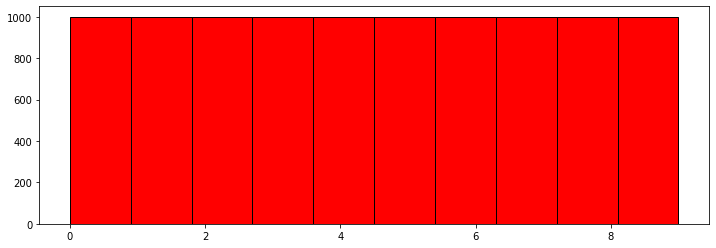

In [ ]:
plt.rcParams["figure.figsize"]=[12,4]
plt.hist(y_val, bins=10, color= 'red', edgecolor='black')
plt.show()

### Respuesta 
i) Los rangos van desde 0 a 255, pues las imagenes en RGB trabajan en ese rango.

ii) Si, tienen igual cantidad de datos por clase

iii) Es conveniente para reducir la escala, pero no es estrictamente necesario.
No se pierde informacion al hacer este procesamiento.

In [ ]:
x_train_vector = x_tr.reshape(-1,28*28)
x_val_vector = x_val.reshape(-1,28*28)

x_train_vector_scaled = x_train_vector/255
x_val_vector_scaled = x_val_vector/255

## 3.c) Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados.

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. **Grafique** como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

**Preguntas:**

i) ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

ii) ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion?

### Respuesta

1. Correspondería usar una función sigmoidal, ya que los valores de entrada están en el rando de [0-1]
2. Si, logra encodear y reconstruir la imagen de salida.

Epoch 1/10
1875/1875 - 6s - loss: 0.3166 - val_loss: 0.3000
Epoch 2/10
1875/1875 - 3s - loss: 0.2970 - val_loss: 0.2982
Epoch 3/10
1875/1875 - 3s - loss: 0.2959 - val_loss: 0.2974
Epoch 4/10
1875/1875 - 3s - loss: 0.2950 - val_loss: 0.2968
Epoch 5/10
1875/1875 - 3s - loss: 0.2946 - val_loss: 0.2977
Epoch 6/10
1875/1875 - 3s - loss: 0.2944 - val_loss: 0.2963
Epoch 7/10
1875/1875 - 3s - loss: 0.2942 - val_loss: 0.2963
Epoch 8/10
1875/1875 - 3s - loss: 0.2942 - val_loss: 0.2967
Epoch 9/10
1875/1875 - 3s - loss: 0.2941 - val_loss: 0.2960
Epoch 10/10
1875/1875 - 3s - loss: 0.2940 - val_loss: 0.2964


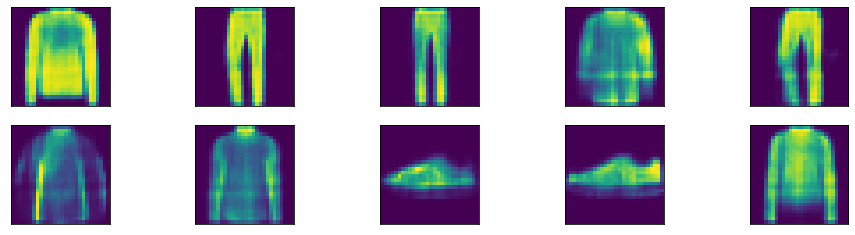

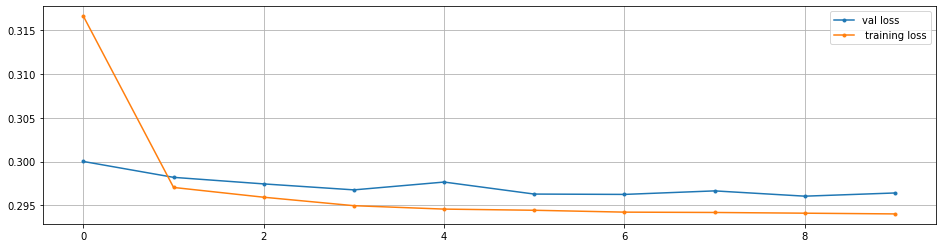

In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD,  Adam
from keras.models import Sequential

autoencoder = Sequential()
autoencoder.add(Dense(32,activation='relu')) # encoder
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder
autoencoder.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
history=autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=10,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=2)
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28))
    ix += 1
plt.show()

plt.plot(history.history['val_loss'],'.-',label= 'val loss')
plt.plot(history.history['loss'],'.-',label= ' training loss')

plt.grid()
plt.legend()
plt.show()

## 3.d) Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

Epoch 1/10
1875/1875 - 4s - loss: 0.2839 - val_loss: 0.2691
Epoch 2/10
1875/1875 - 3s - loss: 0.2650 - val_loss: 0.2657
Epoch 3/10
1875/1875 - 3s - loss: 0.2628 - val_loss: 0.2645
Epoch 4/10
1875/1875 - 3s - loss: 0.2619 - val_loss: 0.2638
Epoch 5/10
1875/1875 - 4s - loss: 0.2615 - val_loss: 0.2641
Epoch 6/10
1875/1875 - 4s - loss: 0.2611 - val_loss: 0.2633
Epoch 7/10
1875/1875 - 4s - loss: 0.2609 - val_loss: 0.2629
Epoch 8/10
1875/1875 - 3s - loss: 0.2608 - val_loss: 0.2632
Epoch 9/10
1875/1875 - 3s - loss: 0.2606 - val_loss: 0.2628
Epoch 10/10
1875/1875 - 3s - loss: 0.2605 - val_loss: 0.2630
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 235)               184475    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               185024    
Total params: 369,499
Trainable params: 369,499

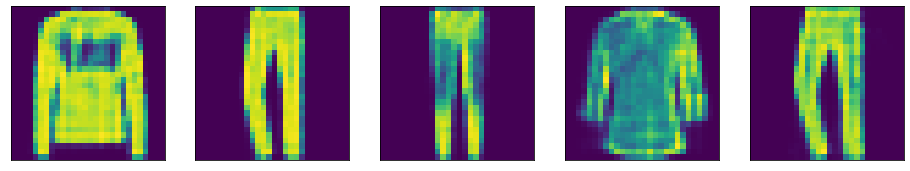

Epoch 1/10
1875/1875 - 4s - loss: 0.2906 - val_loss: 0.2749
Epoch 2/10
1875/1875 - 3s - loss: 0.2711 - val_loss: 0.2719
Epoch 3/10
1875/1875 - 3s - loss: 0.2692 - val_loss: 0.2712
Epoch 4/10
1875/1875 - 3s - loss: 0.2686 - val_loss: 0.2706
Epoch 5/10
1875/1875 - 3s - loss: 0.2682 - val_loss: 0.2699
Epoch 6/10
1875/1875 - 3s - loss: 0.2680 - val_loss: 0.2706
Epoch 7/10
1875/1875 - 3s - loss: 0.2677 - val_loss: 0.2700
Epoch 8/10
1875/1875 - 3s - loss: 0.2676 - val_loss: 0.2698
Epoch 9/10
1875/1875 - 3s - loss: 0.2675 - val_loss: 0.2695
Epoch 10/10
1875/1875 - 3s - loss: 0.2675 - val_loss: 0.2696
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 117)               91845     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               92512     
Total params: 184,357
Trainable params: 184,357

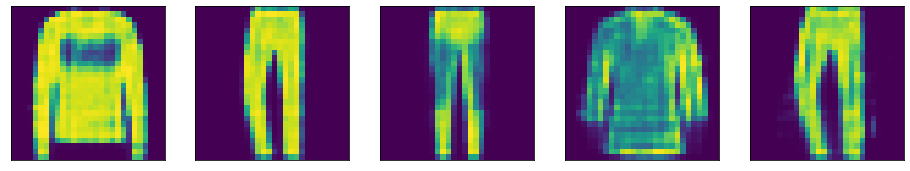

Epoch 1/10
1875/1875 - 4s - loss: 0.3020 - val_loss: 0.2856
Epoch 2/10
1875/1875 - 3s - loss: 0.2822 - val_loss: 0.2835
Epoch 3/10
1875/1875 - 3s - loss: 0.2807 - val_loss: 0.2820
Epoch 4/10
1875/1875 - 3s - loss: 0.2800 - val_loss: 0.2824
Epoch 5/10
1875/1875 - 3s - loss: 0.2797 - val_loss: 0.2818
Epoch 6/10
1875/1875 - 3s - loss: 0.2794 - val_loss: 0.2813
Epoch 7/10
1875/1875 - 3s - loss: 0.2792 - val_loss: 0.2814
Epoch 8/10
1875/1875 - 3s - loss: 0.2791 - val_loss: 0.2812
Epoch 9/10
1875/1875 - 3s - loss: 0.2790 - val_loss: 0.2815
Epoch 10/10
1875/1875 - 3s - loss: 0.2789 - val_loss: 0.2812
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 54)                42390     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               43120     
Total params: 85,510
Trainable params: 85,510
N

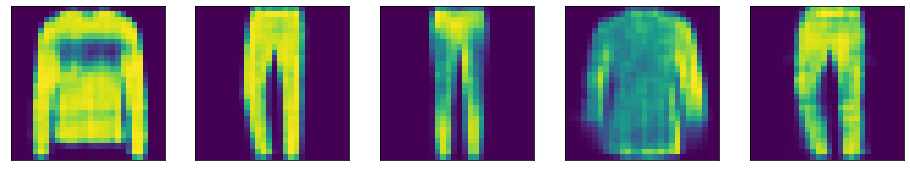

Epoch 1/10
1875/1875 - 4s - loss: 0.4576 - val_loss: 0.4362
Epoch 2/10
1875/1875 - 3s - loss: 0.4313 - val_loss: 0.4292
Epoch 3/10
1875/1875 - 3s - loss: 0.4273 - val_loss: 0.4276
Epoch 4/10
1875/1875 - 3s - loss: 0.4265 - val_loss: 0.4273
Epoch 5/10
1875/1875 - 3s - loss: 0.4263 - val_loss: 0.4271
Epoch 6/10
1875/1875 - 3s - loss: 0.4262 - val_loss: 0.4270
Epoch 7/10
1875/1875 - 3s - loss: 0.4262 - val_loss: 0.4270
Epoch 8/10
1875/1875 - 3s - loss: 0.4261 - val_loss: 0.4270
Epoch 9/10
1875/1875 - 3s - loss: 0.4261 - val_loss: 0.4269
Epoch 10/10
1875/1875 - 3s - loss: 0.4261 - val_loss: 0.4270
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non

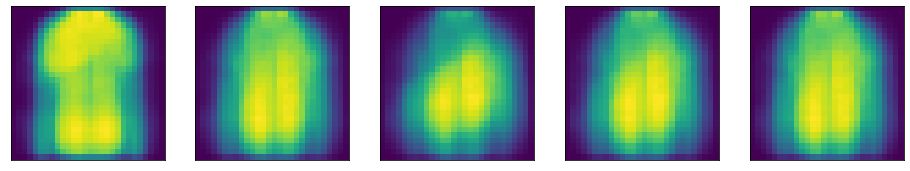

In [ ]:
plt.rcParams["figure.figsize"]=[16,12]
label=[]
data=[]

for i in [28*28*0.3,28*28*0.15,28*28*0.07,2]:
  autoencoder = Sequential()
  autoencoder.add(Dense(int(i),activation='relu', input_shape=(28*28,))) # encoder
  autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder
  autoencoder.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
  history=autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=10,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=2)
  label.append('neu: '+str(int(i)))
  data.append(history)
  autoencoder.summary()
  ix = 1
  for u in range(5):
    ax = plt.subplot(1,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28))
    ix += 1
  plt.show()

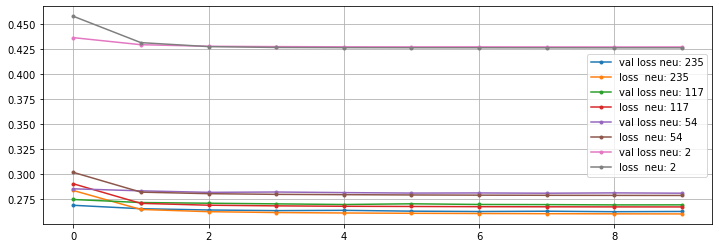

In [ ]:
plt.rcParams["figure.figsize"]=[12,4]
for i, datos in enumerate(data[:4]):
  plt.plot(datos.history['val_loss'],'.-',label= 'val loss ' + label[i])
  plt.plot(datos.history['loss'],'.-',label= 'loss  ' +label[i])

plt.grid()
plt.legend()
plt.show()

### Respuesta
Se observa que a menor cantidad de neuronas, la nitidez de la imagen de salida se vuelve mas difusa. 

## 3.e) Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 

**Preguntas:**

i) ¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

ii) ¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5026 - val_loss: 0.4920
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4905 - val_loss: 0.4915
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4907 - val_loss: 0.4912
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4905 - val_loss: 0.4914
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4906 - val_loss: 0.4913
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4910 - val_loss: 0.4917
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4907 - val_loss: 0.4912
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4908 - val_loss: 0.4915
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4902 - val_loss: 0.4912
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.490

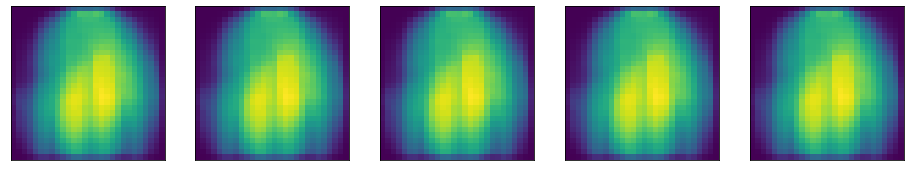

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_15 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_16 (Dense)             (None, 784)              

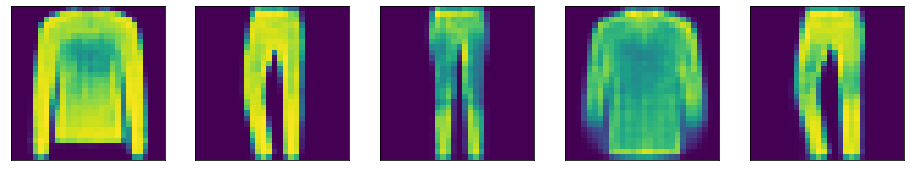

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_18 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_19 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_20 (Dense)             (None, 17)                1717      
_________________________________________________________________
dense_21 (Dense)             (None, 100)               1800      
_________________________________________________________________
dense_22 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_23 (Dense)             (None, 784)              

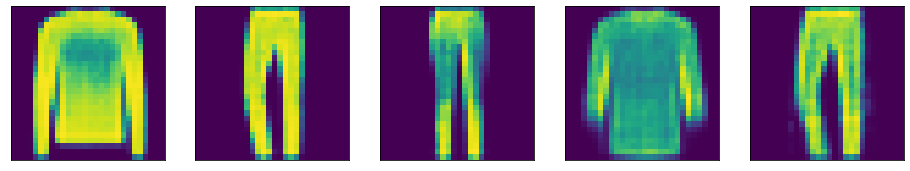

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_25 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_27 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_28 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_29 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_30 (Dense)             (None, 784)              

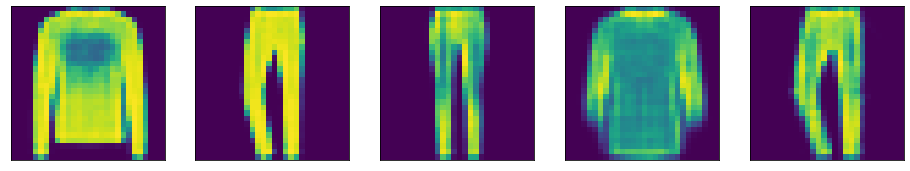

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_32 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_33 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_34 (Dense)             (None, 47)                4747      
_________________________________________________________________
dense_35 (Dense)             (None, 100)               4800      
_________________________________________________________________
dense_36 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_37 (Dense)             (None, 784)              

In [ ]:
for neu in range(2,50,15):
  autoencoder = Sequential()
  autoencoder.add(Dense(500,activation='relu', input_shape=(28*28,))) # encoder
  autoencoder.add(Dense(200,activation= 'relu'))
  autoencoder.add(Dense(100,activation= 'relu'))
  autoencoder.add(Dense(neu,activation= 'relu'))
  autoencoder.add(Dense(100,activation= 'relu'))
  autoencoder.add(Dense(200,activation= 'relu'))
  autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder
  autoencoder.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
  history=autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=10,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=1)

  data.append(history)
  label.append("Dense layers = "+"[500,200,100,"+str(neu)+",100,200,28*28]")
  for ix in range(1,6):
    ax = plt.subplot(1,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28))
  plt.show()
  autoencoder.summary()


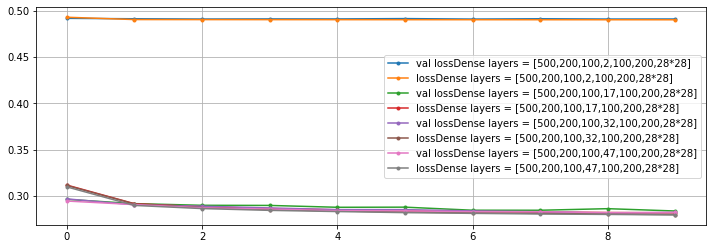

In [ ]:
for i in range(4,8):
  plt.plot(data[i].history['val_loss'],'.-',label= 'val loss' + label[i])
  plt.plot(data[i].history['loss'],'.-',label= 'loss' +label[i])

plt.grid()
plt.legend()
plt.show()

## 3.f) Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

##only convolutional

In [ ]:
x_tr_scaled=x_tr.reshape(60000, 28, 28, 1)/255
x_val_scaled=x_val.reshape(10000, 28, 28, 1)/255

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential
conv=Sequential()
#E
conv.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))

#D
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'))
conv.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
conv.summary()
history = conv.fit(x_tr_scaled,x_tr_scaled,epochs=10,validation_data=(x_val_scaled,x_val_scaled), verbose=2)
data.append(history)
label.append("undense conv")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)      

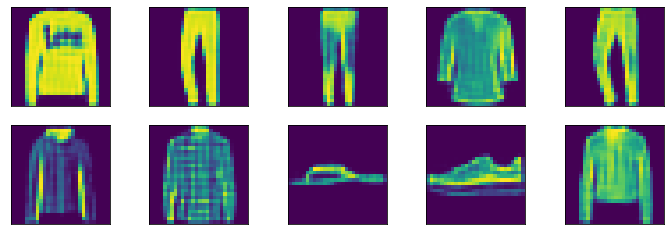

In [ ]:
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(conv.predict(x_val_scaled)[ix].reshape(28,28))
    ix += 1
plt.show()

##convolutional and dense

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense, Reshape
from keras.optimizers import SGD
from keras.models import Sequential


In [ ]:
conv=Sequential()
#E
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))
#dense
conv.add(Flatten())
conv.add(Dense(64,activation='relu'))
conv.add(Dense(7*7*8,activation='relu'))
conv.add(Reshape((7, 7, 8)))

conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'))
conv.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
conv.summary()
history = conv.fit(x_tr_scaled,x_tr_scaled,epochs=10,validation_data=(x_val_scaled,x_val_scaled), verbose=1)
data.append(history)
label.append("dense conv")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                25152     
_________________________________________________________________
dense_39 (Dense)             (None, 392)             

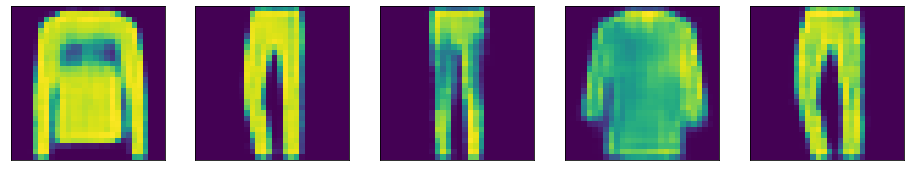

In [ ]:
ix = 1
for u in range(5):
  ax = plt.subplot(1,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(conv.predict(x_val_scaled)[ix].reshape(28,28))
  ix += 1
plt.show()

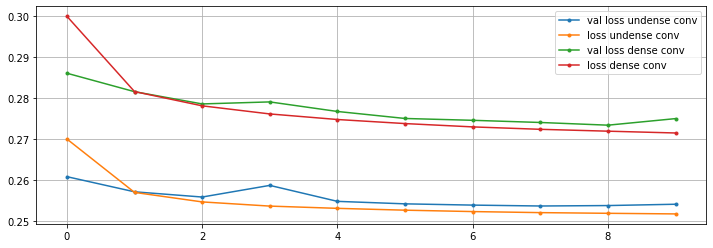

In [ ]:
for i in range(8,10):
  plt.plot(data[i].history['val_loss'],'.-',label= 'val loss ' + label[i])
  plt.plot(data[i].history['loss'],'.-',label= 'loss ' +label[i])

plt.grid()
plt.legend()
plt.show()

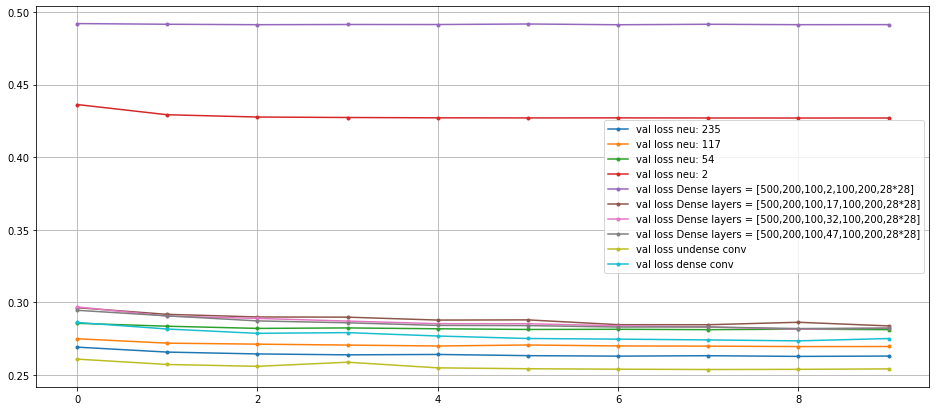

In [ ]:
plt.rcParams["figure.figsize"]=[16,7]

for i, datos in enumerate(data):
  plt.plot(datos.history['val_loss'],'.-',label= 'val loss '+ label[i])
  # plt.plot(datos.history['loss'],'.-',label= 'loss '+ label[i])

plt.grid()
plt.legend()
plt.show()

##observacion
Al agregar capas densas entre el decoder y el encoder, aumenta bastante el error de validación 

## 3.g) Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy`. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patrón de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imágen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida. Pruebe igualmente entregarle a la red nuevas.

In [ ]:
def noise_dataset(x_tr,x_val, noise):
  x_tr_noise=np.zeros((60000,28,28,1))
  x_val_noise=np.zeros((10000,28,28,1))
  for i in range(x_tr.shape[0]):
    img = x_tr[i]   # numpy-array of shape (N, M); dtype=np.uint8
    noisy_img = img + np.random.normal(0, noise, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 1) 
    x_tr_noise[i]= noisy_img_clipped.reshape(28,28,1)
  for i in range(x_val.shape[0]):
    img = x_val[i]   # numpy-array of shape (N, M); dtype=np.uint8
    noisy_img = img + np.random.normal(0, noise, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 1) 
    x_val_noise[i]= noisy_img_clipped.reshape(28,28,1)
  return x_tr_noise, x_val_noise

Epoch 1/10
1875/1875 - 10s - loss: 0.3546 - val_loss: 0.3438
Epoch 2/10
1875/1875 - 9s - loss: 0.3391 - val_loss: 0.3385
Epoch 3/10
1875/1875 - 9s - loss: 0.3355 - val_loss: 0.3361
Epoch 4/10
1875/1875 - 9s - loss: 0.3338 - val_loss: 0.3346
Epoch 5/10
1875/1875 - 9s - loss: 0.3328 - val_loss: 0.3342
Epoch 6/10
1875/1875 - 9s - loss: 0.3321 - val_loss: 0.3332
Epoch 7/10
1875/1875 - 9s - loss: 0.3316 - val_loss: 0.3327
Epoch 8/10
1875/1875 - 9s - loss: 0.3312 - val_loss: 0.3326
Epoch 9/10
1875/1875 - 9s - loss: 0.3310 - val_loss: 0.3323
Epoch 10/10
1875/1875 - 9s - loss: 0.3307 - val_loss: 0.3321


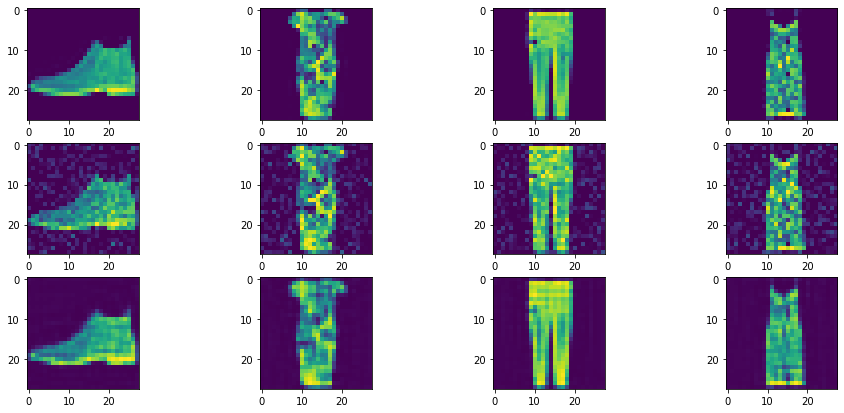

Epoch 1/10
1875/1875 - 10s - loss: 0.4104 - val_loss: 0.3946
Epoch 2/10
1875/1875 - 9s - loss: 0.3896 - val_loss: 0.3890
Epoch 3/10
1875/1875 - 9s - loss: 0.3852 - val_loss: 0.3859
Epoch 4/10
1875/1875 - 9s - loss: 0.3833 - val_loss: 0.3838
Epoch 5/10
1875/1875 - 9s - loss: 0.3824 - val_loss: 0.3831
Epoch 6/10
1875/1875 - 9s - loss: 0.3819 - val_loss: 0.3828
Epoch 7/10
1875/1875 - 9s - loss: 0.3815 - val_loss: 0.3826
Epoch 8/10
1875/1875 - 9s - loss: 0.3812 - val_loss: 0.3825
Epoch 9/10
1875/1875 - 9s - loss: 0.3810 - val_loss: 0.3822
Epoch 10/10
1875/1875 - 9s - loss: 0.3807 - val_loss: 0.3821


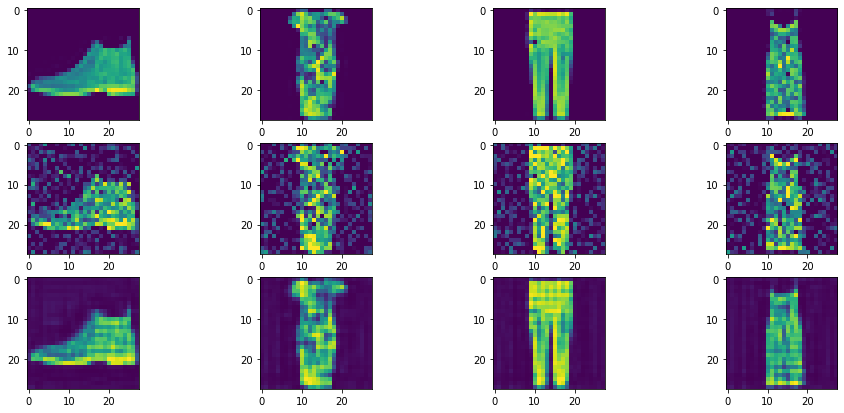

Epoch 1/10
1875/1875 - 10s - loss: 0.4556 - val_loss: 0.4330
Epoch 2/10
1875/1875 - 9s - loss: 0.4258 - val_loss: 0.4239
Epoch 3/10
1875/1875 - 9s - loss: 0.4200 - val_loss: 0.4192
Epoch 4/10
1875/1875 - 9s - loss: 0.4171 - val_loss: 0.4167
Epoch 5/10
1875/1875 - 9s - loss: 0.4154 - val_loss: 0.4151
Epoch 6/10
1875/1875 - 9s - loss: 0.4142 - val_loss: 0.4142
Epoch 7/10
1875/1875 - 9s - loss: 0.4134 - val_loss: 0.4137
Epoch 8/10
1875/1875 - 9s - loss: 0.4128 - val_loss: 0.4131
Epoch 9/10
1875/1875 - 9s - loss: 0.4124 - val_loss: 0.4129
Epoch 10/10
1875/1875 - 9s - loss: 0.4121 - val_loss: 0.4126


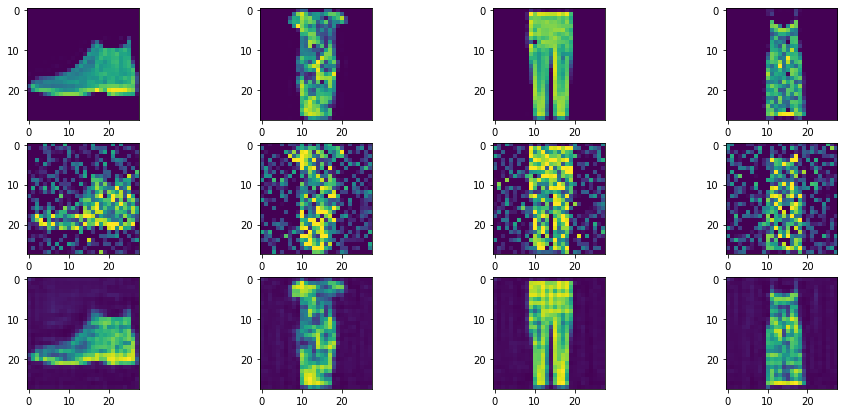

Epoch 1/10
1875/1875 - 10s - loss: 0.4856 - val_loss: 0.4612
Epoch 2/10
1875/1875 - 9s - loss: 0.4535 - val_loss: 0.4510
Epoch 3/10
1875/1875 - 9s - loss: 0.4487 - val_loss: 0.4478
Epoch 4/10
1875/1875 - 9s - loss: 0.4449 - val_loss: 0.4435
Epoch 5/10
1875/1875 - 9s - loss: 0.4422 - val_loss: 0.4418
Epoch 6/10
1875/1875 - 9s - loss: 0.4403 - val_loss: 0.4417
Epoch 7/10
1875/1875 - 9s - loss: 0.4385 - val_loss: 0.4386
Epoch 8/10
1875/1875 - 9s - loss: 0.4370 - val_loss: 0.4369
Epoch 9/10
1875/1875 - 9s - loss: 0.4357 - val_loss: 0.4353
Epoch 10/10
1875/1875 - 9s - loss: 0.4349 - val_loss: 0.4348


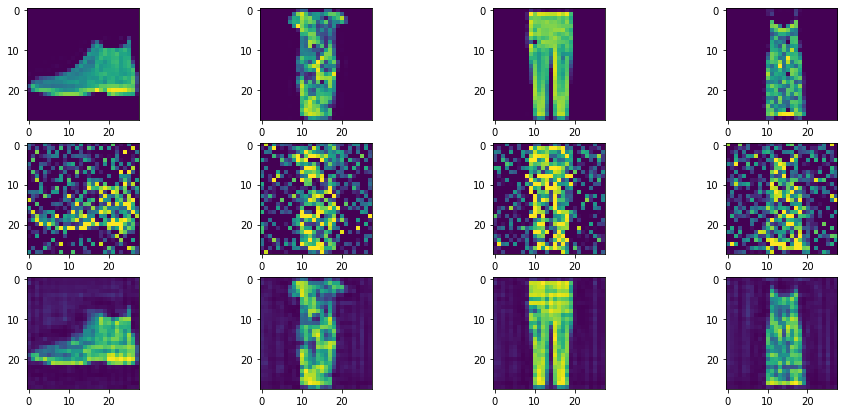

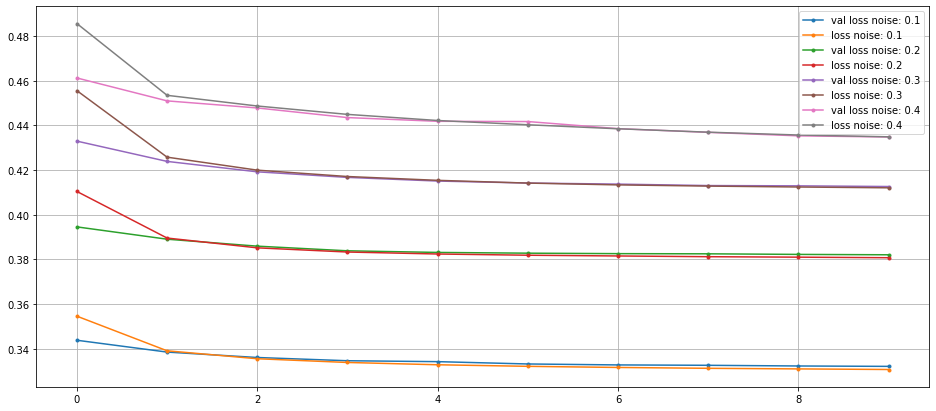

In [ ]:
noise_data=[]
noise_vals=[0.1,0.2,0.3,0.4]
for noise in noise_vals:
  x_tr_noise,x_val_noise = noise_dataset(x_tr_scaled,x_val_scaled , noise)
  conv=Sequential()
  #E
  conv.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
  conv.add(MaxPooling2D(pool_size=(2,2)))
  conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
  conv.add(MaxPooling2D(pool_size=(2,2)))
  conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
  conv.add(UpSampling2D((2, 2)))

  #D
  conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
  conv.add(UpSampling2D((2, 2)))
  conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'))
  conv.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')
  history = conv.fit(x_tr_noise,x_tr_noise,epochs=10,validation_data=(x_val_noise,x_val_noise), verbose=2)
  noise_data.append(history)
  plt.subplots(3,4)
  for i in range(4):
    plt.subplot(3,4,i+1)
    plt.imshow(x_val_scaled[100*i].reshape(28,28))
    plt.subplot(3,4,5+i)
    plt.imshow(x_val_noise[100*i].reshape(28,28))
    plt.subplot(3,4,9+i)
    plt.imshow(conv.predict(x_val_scaled)[100*i].reshape(28,28))
  plt.show()

for i,noised_datos in enumerate(noise_data):
  plt.plot(noised_datos.history['val_loss'],'.-',label= 'val loss noise: '+str(noise_vals[i]))
  plt.plot(noised_datos.history['loss'],'.-',label= 'loss noise: '+str(noise_vals[i]))

plt.grid()
plt.legend()
plt.show()

## 3.h) Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imágenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imágen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imágenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imágen resultante utilizando el decoder. ¿Qué observa? Muestre las imágenes obtenidas junto con otras imágenes de la misma categoría que la imágen que utilizó originalmente. Pruebe con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imágen obtenida al promediar las representaciones comprimidas de varias (o todas) las imágenes de una clase. Utilice el encoder para generar imágenes a partir de otros valores que se les ocurran y especule sobre el por qué la imágen obtenida se asimila o no a las imágenes del dataset. 

In [ ]:
conv=Sequential()
#Encoder
conv.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))

#Decoder
conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',input_shape=(7,7,32)))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'))
conv.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy')

history = conv.fit(x_tr_scaled,x_tr_noise,epochs=10,validation_data=(x_val_noise,x_val_noise), verbose=2)

encoder=Sequential(conv.layers[:4])
decoder=Sequential(conv.layers[4:])


Epoch 1/10
1875/1875 - 12s - loss: 0.5256 - val_loss: 0.5071
Epoch 2/10
1875/1875 - 11s - loss: 0.5211 - val_loss: 0.5002
Epoch 3/10
1875/1875 - 11s - loss: 0.5204 - val_loss: 0.5000
Epoch 4/10
1875/1875 - 11s - loss: 0.5200 - val_loss: 0.5001
Epoch 5/10
1875/1875 - 11s - loss: 0.5198 - val_loss: 0.4932
Epoch 6/10
1875/1875 - 11s - loss: 0.5197 - val_loss: 0.4950
Epoch 7/10
1875/1875 - 11s - loss: 0.5196 - val_loss: 0.4961
Epoch 8/10
1875/1875 - 11s - loss: 0.5195 - val_loss: 0.4924
Epoch 9/10
1875/1875 - 11s - loss: 0.5194 - val_loss: 0.4912
Epoch 10/10


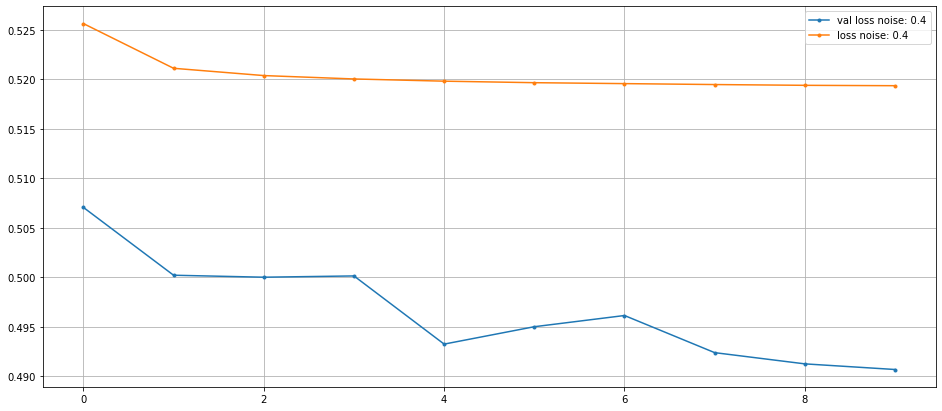

In [ ]:
plt.plot(history.history['val_loss'],'.-',label= 'val loss noise: '+str(noise_vals[i]))
plt.plot(history.history['loss'],'.-',label= 'loss noise: '+str(noise_vals[i]))

plt.grid()
plt.legend()
plt.show()

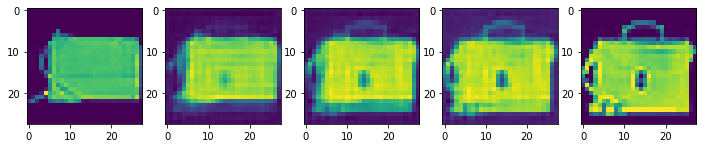

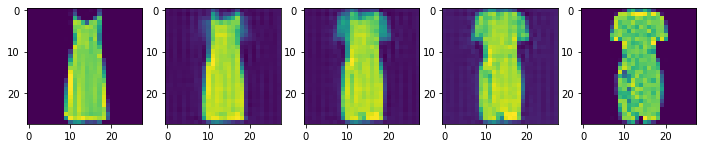

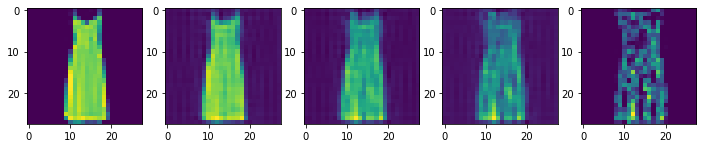

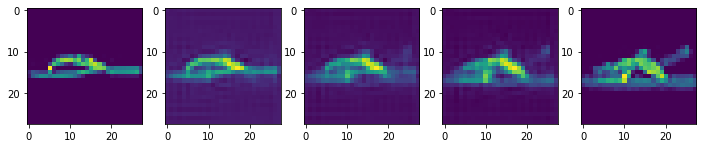

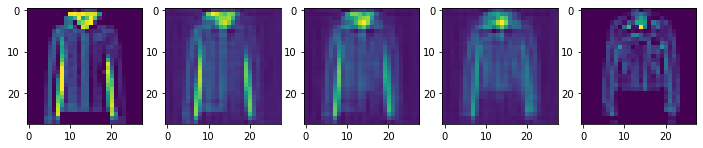

In [ ]:
plt.rcParams["figure.figsize"]=[12,4]

for i in range(5):
  plt.subplots(1,5)
  random=randint(0,10000)
  image1=x_val_scaled[random].reshape(1,28,28,1)
  cont=0
  while y_val[cont]!=y_val[random]:
    cont+=1
  image2=x_val_scaled[cont].reshape(1,28,28,1)
  
  encoded_image1=encoder.predict(image1)
  encoded_image2=encoder.predict(image2)
  
  encoded_result25=(encoded_image1*0.25+encoded_image2*0.75)
  encoded_result50=(encoded_image1+encoded_image2)/2
  encoded_result75=(encoded_image1*0.75+encoded_image2*0.25)
  
  # noisy_img = encoded_image + np.random.normal(0, 0.2, encoded_image.shape)
  # noisy_img_clipped = np.clip(noisy_img, 0, 1) 

  pred1=decoder.predict(encoded_result25)
  pred2=decoder.predict(encoded_result50)
  pred3=decoder.predict(encoded_result75)

  plt.subplot(1,5,1)
  plt.imshow(x_val_scaled[cont].reshape(28,28))
  plt.subplot(1,5,2)
  plt.imshow(pred1.reshape(28,28))
  plt.subplot(1,5,3)
  plt.imshow(pred2.reshape(28,28))
  plt.subplot(1,5,4)
  plt.imshow(pred3.reshape(28,28))
  plt.subplot(1,5,5)
  plt.imshow(x_val_scaled[random].reshape(28,28))
  plt.show()

# 4. GAN para MNIST 

Probablemente uno de los desarrollos recientes del area de las redes neuronales más interesantes son las GAN, o _Generative Adversarial Networks_. Estas han deslumbrado al mundo los últimos años generando resultados inesperados, como los llamados _deep fakes_ (https://www.youtube.com/watch?v=25GjijODWoI&ab_channel=Borked), caras no no existentes generadas artificialmente, entre muchas otras aplicaciones de las cuales las más creativas y divertidas son ampliamente divulgadas. Estos resultados nos dan cuenta que estas redes cuando son implementadas correctamente tienen la habilidad de realizar tareas muy especificas logrando desempeños que en logran incluso en algunos casos engañar a observadores humanos.

<img src="https://jrmerwin.github.io/deeplearning4j-docs/img/GANs.png" background="white">

Dependiendo del problema que uno quiera resolver las GAN no requieren datos etiquetados. Esto lo logran gracias a su estructura adversarial, es decir, donde simultaneamente se entrenan dos redes, una especializada en generar datos y otra red especializada en discriminar datos verdaderos de datos falsos, en su configuración más simple al menos. En esta parte de la tarea deberan generar una red de este tipo que genere dígitos que aparenten ser hechos a mano. Para esto utilizaremos las imágenes de entrenamiento del dataset MNIST que ya conocen.


## 4.a) Primera GAN

El código siguiente contiene todos los ingredientes para entrenar una red GAN, se encuentra áltamente comentada para su entendimiento. Usted deberá incluir funcionalidades al código, no incluya aún ninguna mejora a la arquitectura de las redes, esto se verá en el item 4.c). Las funcionalidades que debe añadir son las siguientes: 

i) Imprimir alguna medida del desempeño tanto del generador como del disciminador (por ejemplo f1-score, precision and recall o accuracy) a lo largo del entrenamiento. ¿Variaciones en esta medidas representan mejoras en nuestra red?

ii) Añadir gráficos de las entradas de data real con un título que indique la clasificación que está dando el discriminador a cada una de estas imágenes (Falsa|Real). El código entregado grafica tan solo las imágenes que genera el generador y la etiqueta que le está dando el discriminador (Falsa|Real).

**Recuero usar entorno de ejecución en GPU**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense, Reshape
from keras.optimizers import SGD
from keras.models import Sequential

In [ ]:
from keras.datasets import mnist
import numpy as np
(x,y),(_,_) = mnist.load_data()
x = x.reshape((-1,28,28,1)).astype(np.float32)
x = x/255

In [ ]:
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
discriminator_net = Sequential() # Discriminador
discriminator_net.add(Conv2D(16, 3, strides=1, input_shape=x.shape[1:], padding='same')) #Recibe como entrada tanto imágenes generadas por el generador como imágenes del dataset
discriminator_net.add(MaxPooling2D(pool_size=(2,2)))
discriminator_net.add(Conv2D(1, 3, strides=2, padding='same'))
discriminator_net.add(Flatten())    #Flatten para pasar a una neurona de capa densa
discriminator_net.add(Dense(1,activation='sigmoid',use_bias=False))   # La salida estará entre 0 y 1.

generator_net = Sequential() 
noise_size=100
generator_net.add(Dense(7*7*10, input_shape=[noise_size]))   # el generador recibirá como entrada ruido, el tamaño es arbitrario.
generator_net.add(Reshape((7,7,10)))    # Transforma la salida de la red densa unidimensional a tridimensional, las primeras dos pueden ser interpretadas como tamaño imágen
                                          # y la tercera como n° canales
generator_net.add(UpSampling2D())   # upsampling2d nos permite pasar de imágenes 7,7,10 a 14,14,10
generator_net.add(Conv2D(32, 3, padding='same')) # podemos añadir convolucionales dada la entrada a esta capa, la primera dimensión transformará la data
                                                      # desde 14,14,10 a 14,14,32
generator_net.add(UpSampling2D()) # pasamos de 14,14,32 a 28,28,32
generator_net.add(Conv2D(1, 4, padding='same',activation='sigmoid')) # hagamos lo que hagamos hay que asegurarse de obtener una salida 28,28,1 como es el caso en esta arquitectura

discriminator = Sequential() # Compilamos el discriminador, sin embargo debemos crear la red auxiliar a discriminator_net, para poder entrenarla independiente del generator
discriminator.add(discriminator_net)
discriminator.compile(loss='binary_crossentropy', optimizer = Adam(lr=0.0002), metrics=['acc']) # compilamos con binary cross entropy

gan = Sequential() # GAN contendrá al generador y al discriminador en serie
gan.add(generator_net) # añadimos inicialmente el generador
for layer in discriminator_net.layers: # y luego el discriminador 
    layer.trainable = False # nos preocupamos de dejar esta capa no entrenable por el compilador, puesto este discrimiador se entrenará con la data real para identificar real|fake
gan.add(discriminator_net) # añadimos las capas ya modificadas para no ser entrenadas
gan.compile(loss='binary_crossentropy', optimizer = Adam(lr=0.0002), metrics=['acc']) #compilamos

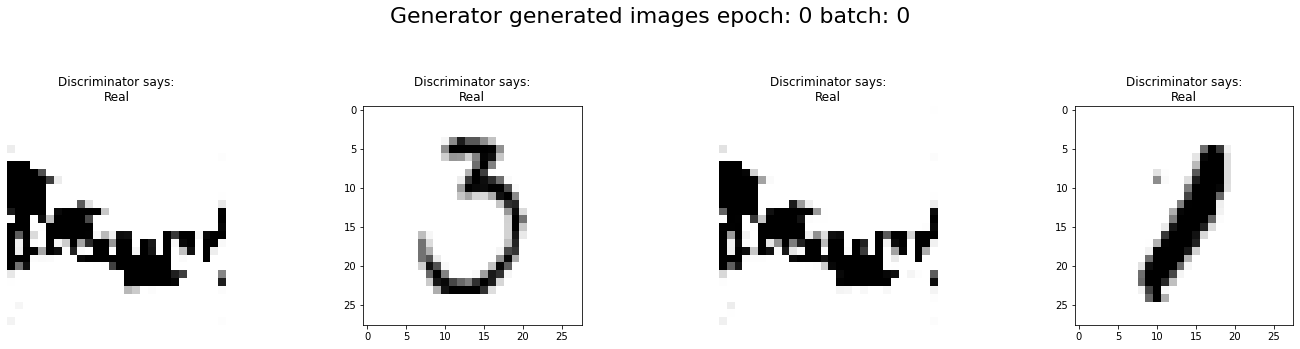

>Accuracy real: 69%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


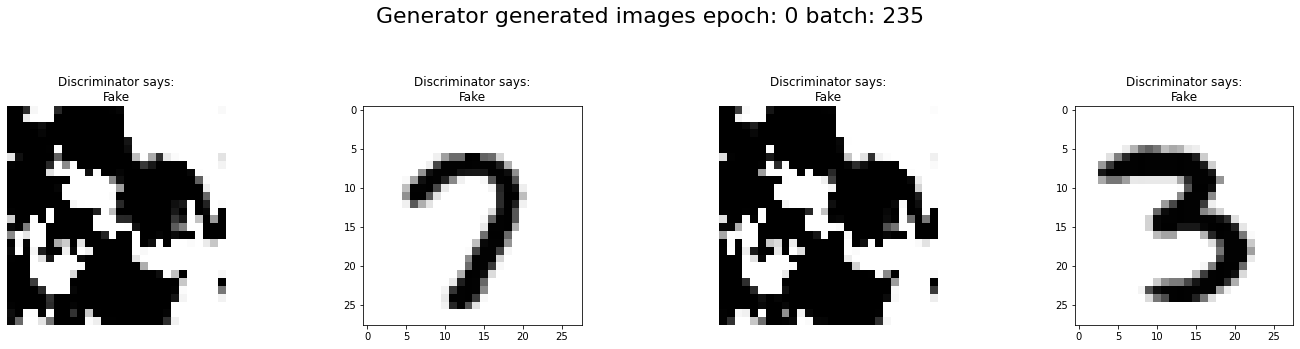

>Accuracy real: 2%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


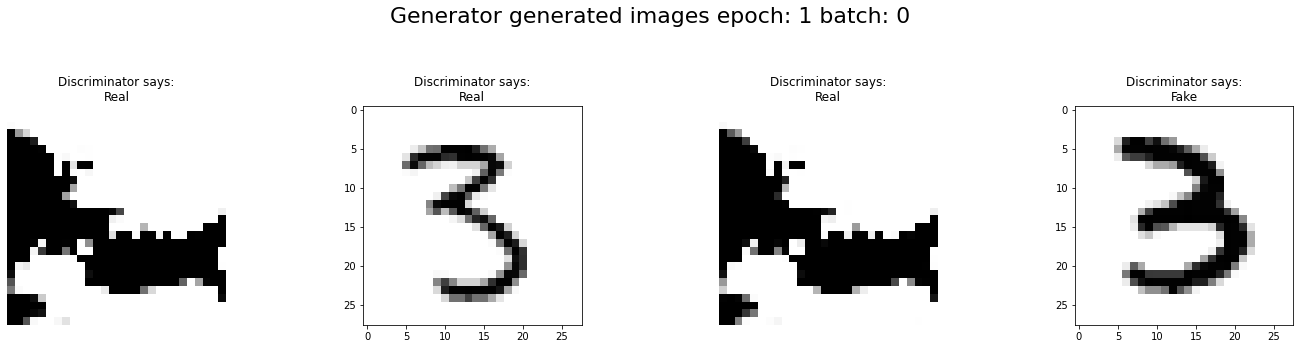

>Accuracy real: 62%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


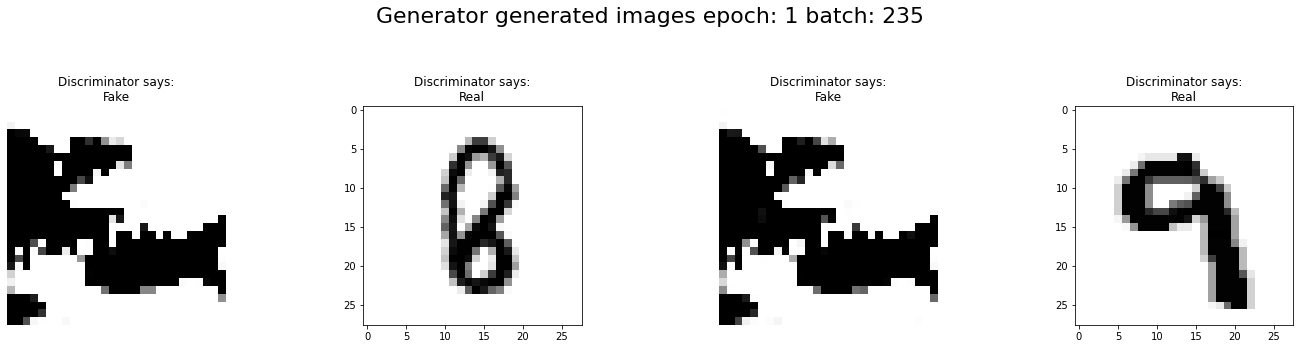

>Accuracy real: 88%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


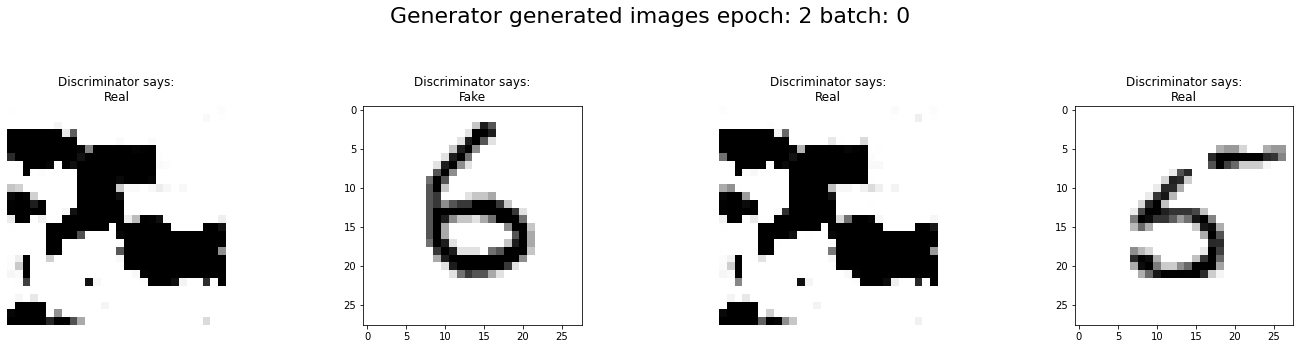

>Accuracy real: 64%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


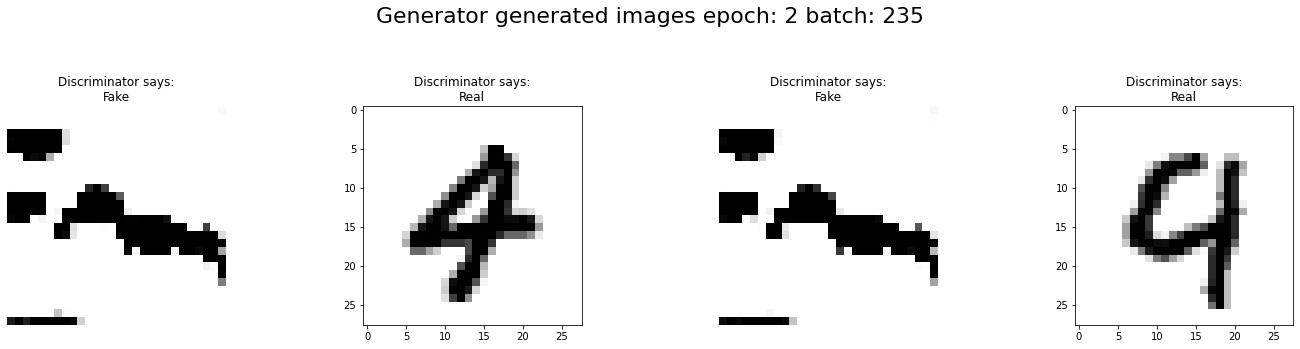

>Accuracy real: 95%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


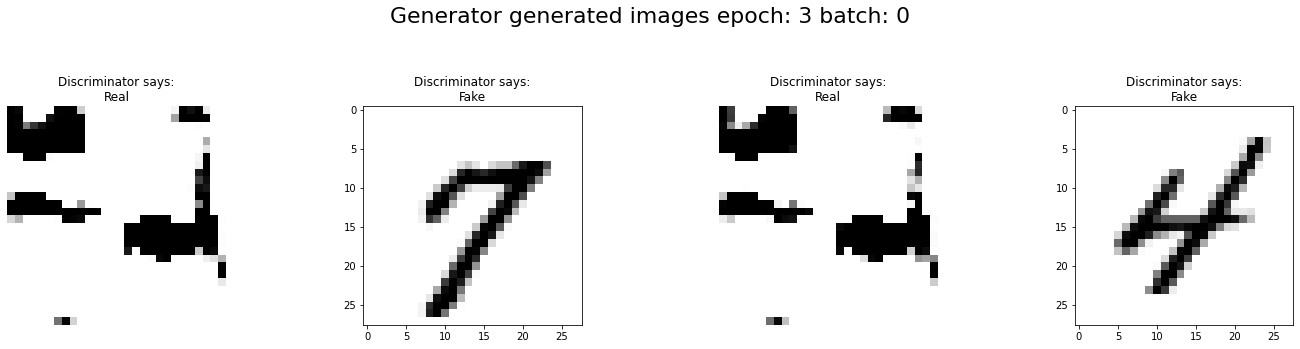

>Accuracy real: 43%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


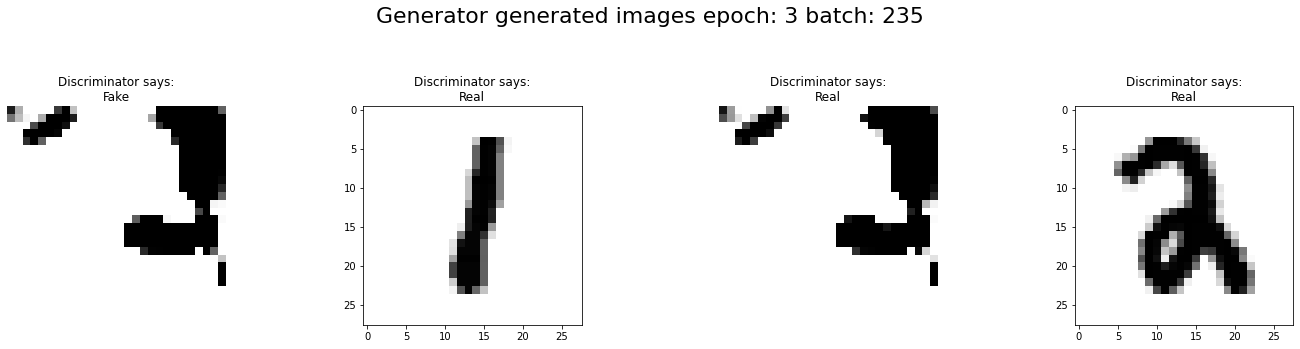

>Accuracy real: 89%, fake: 4%
------------------------------------------------------------------------------------------------------------------------


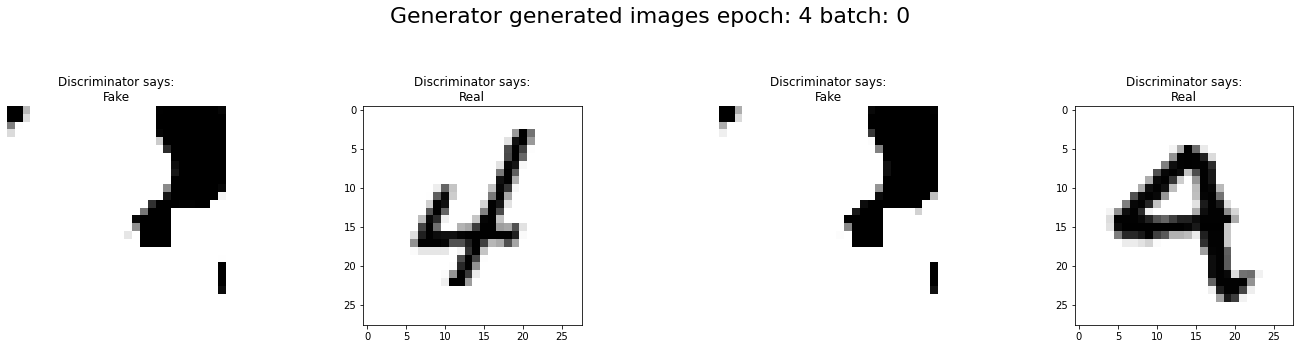

>Accuracy real: 93%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


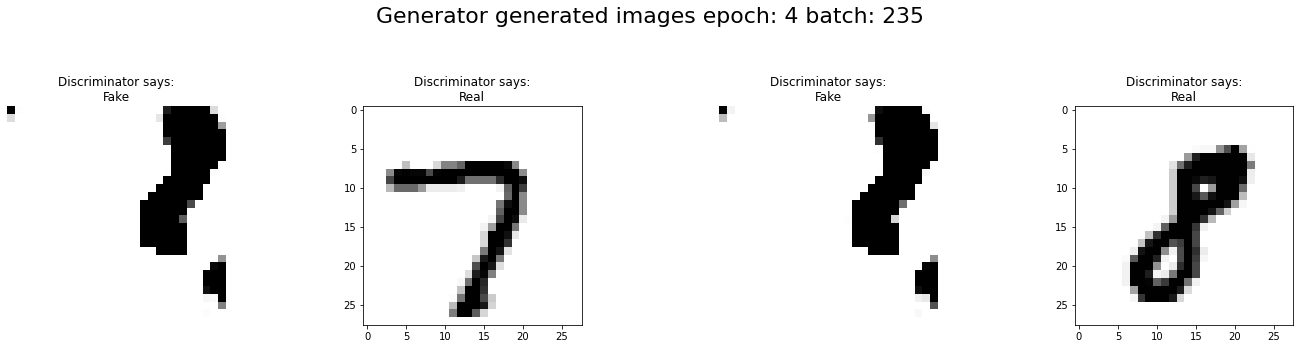

>Accuracy real: 93%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


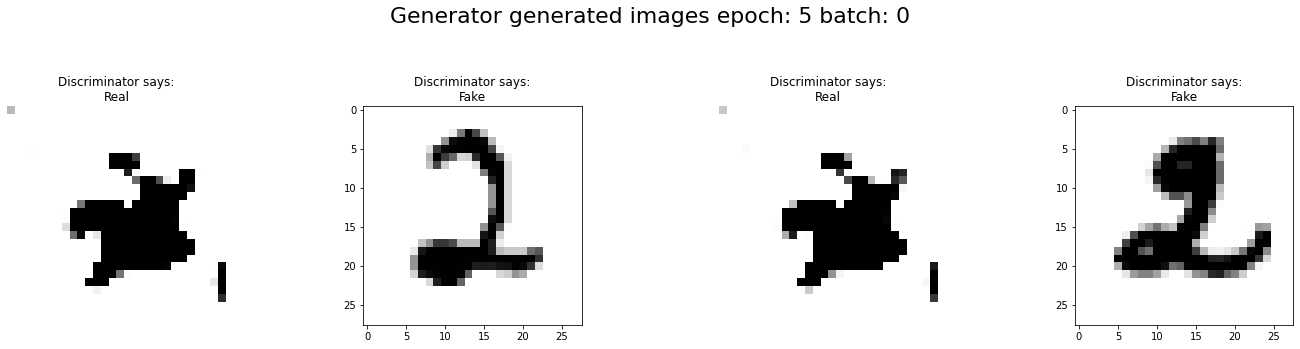

>Accuracy real: 35%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


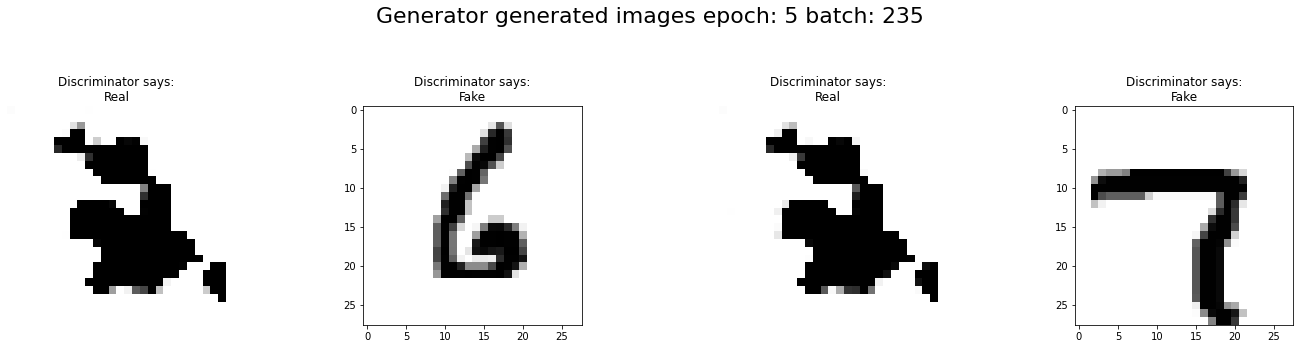

>Accuracy real: 22%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


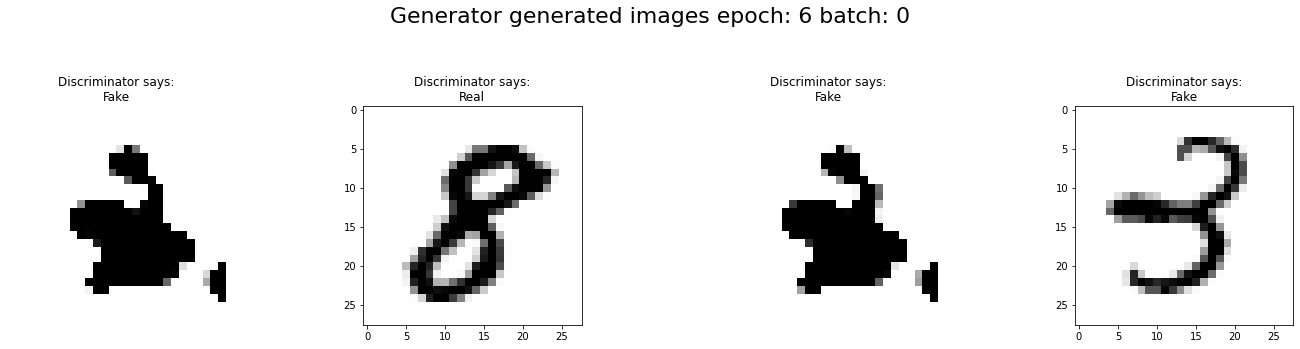

>Accuracy real: 73%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


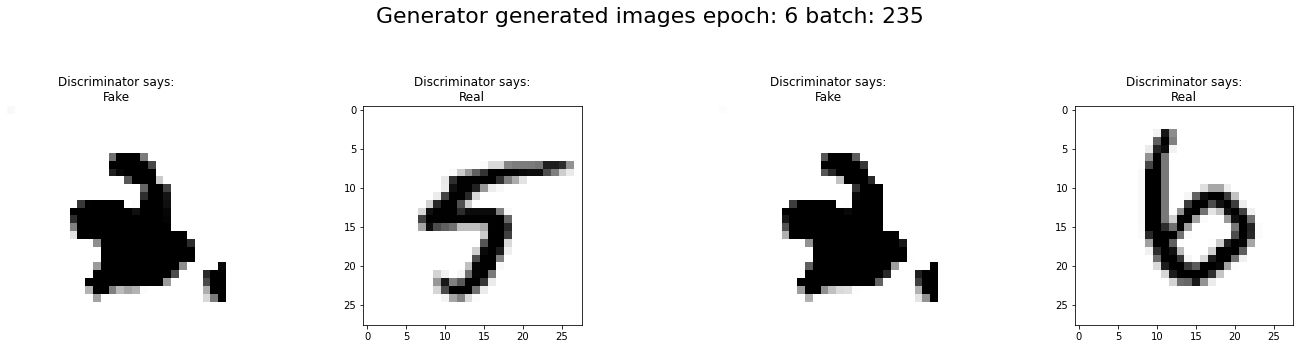

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


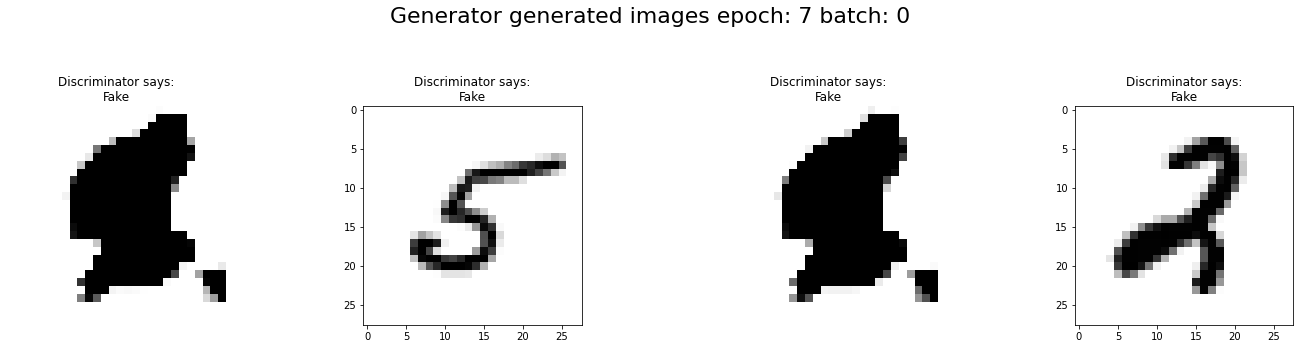

>Accuracy real: 71%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


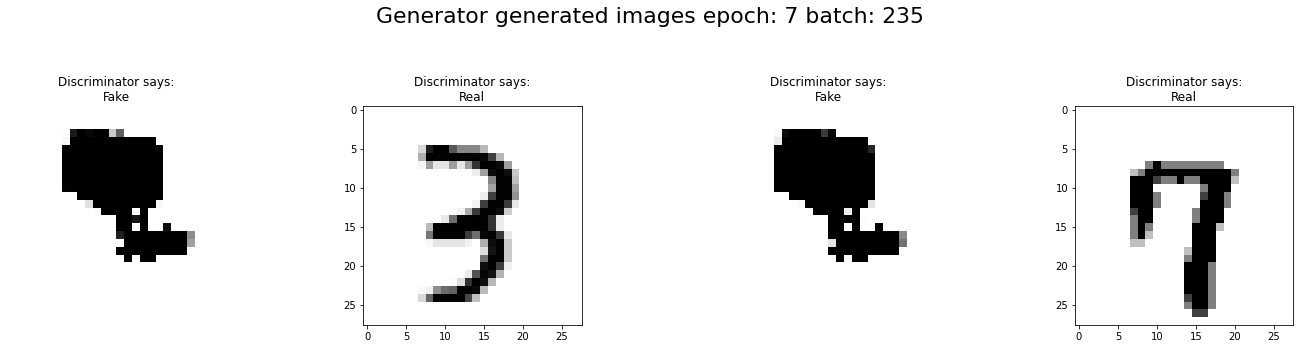

>Accuracy real: 75%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


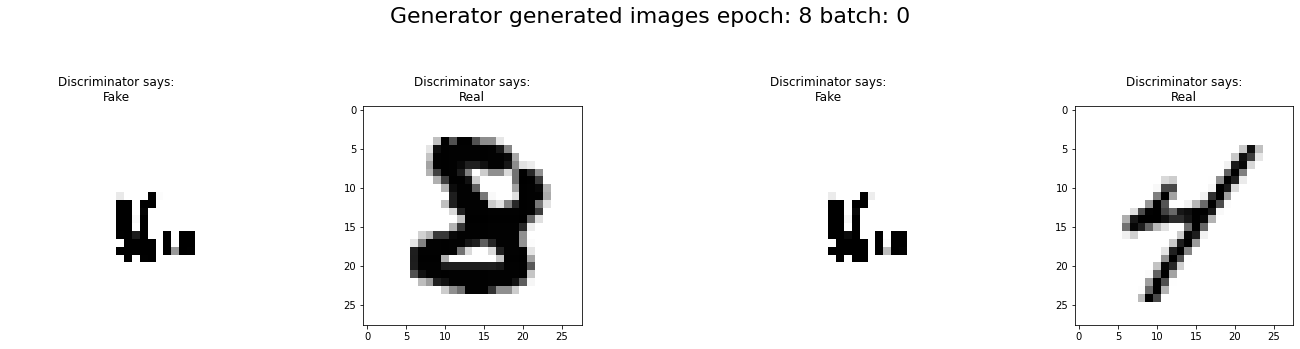

>Accuracy real: 52%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


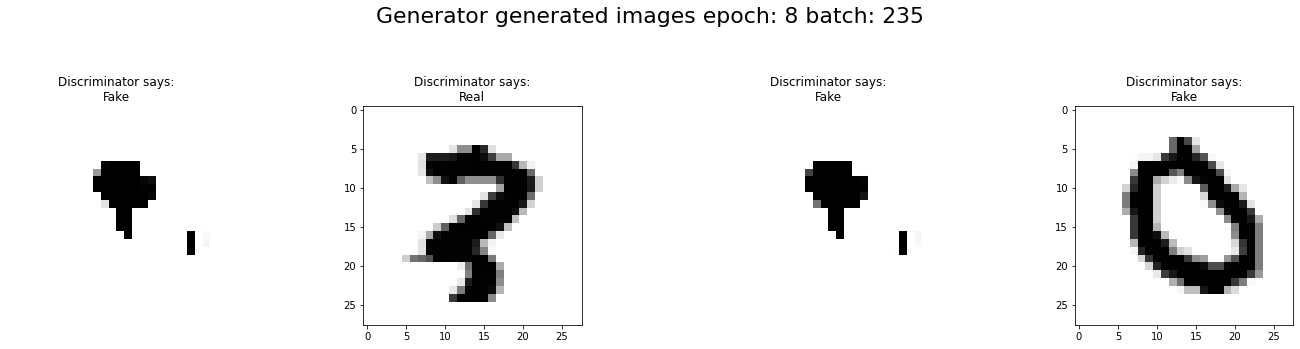

>Accuracy real: 66%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


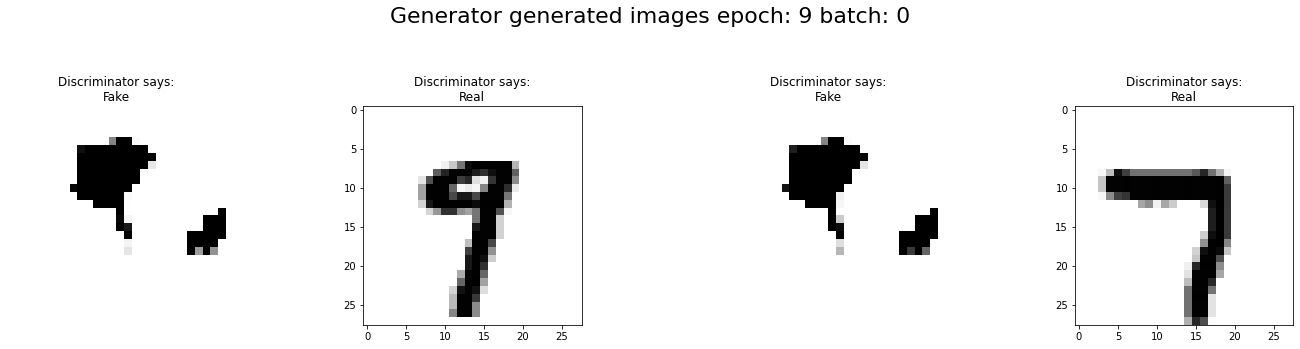

>Accuracy real: 86%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


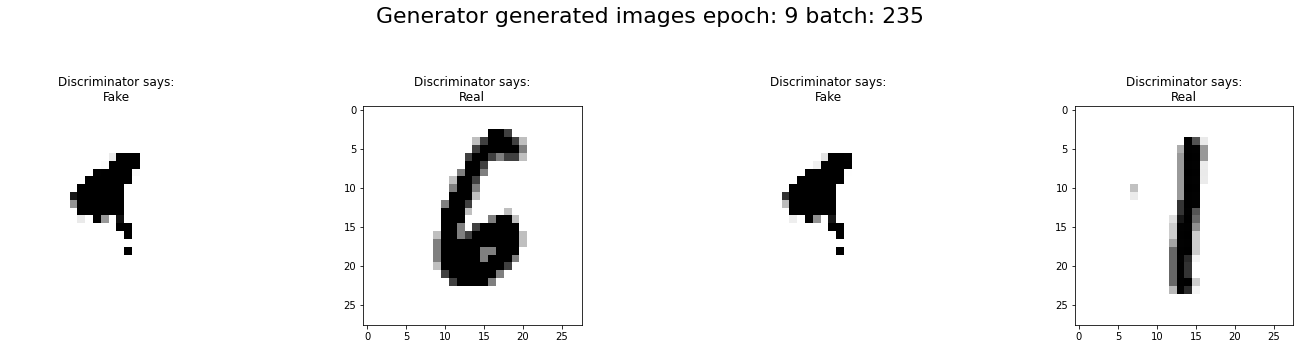

>Accuracy real: 88%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


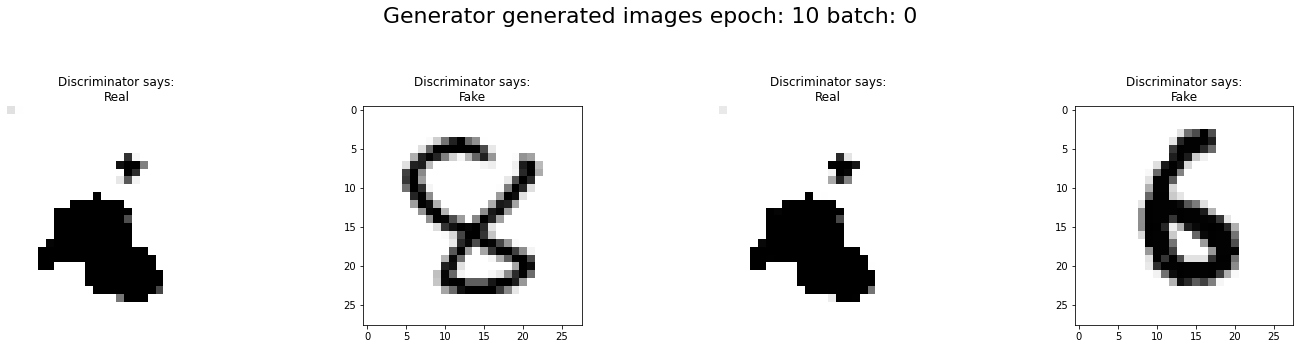

>Accuracy real: 12%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


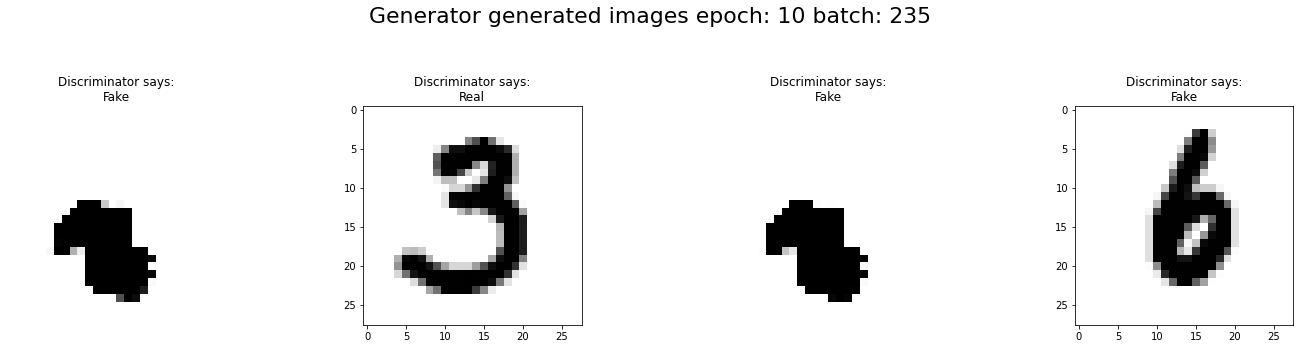

>Accuracy real: 67%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


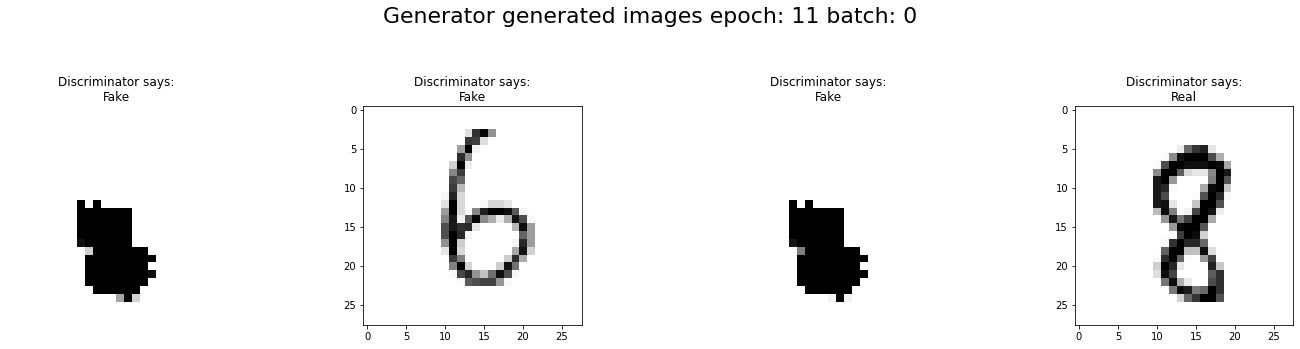

>Accuracy real: 90%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


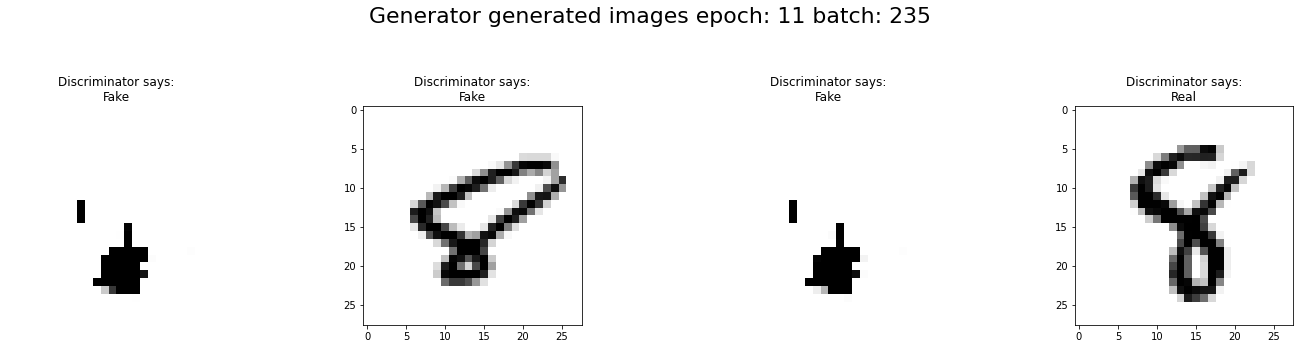

>Accuracy real: 83%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


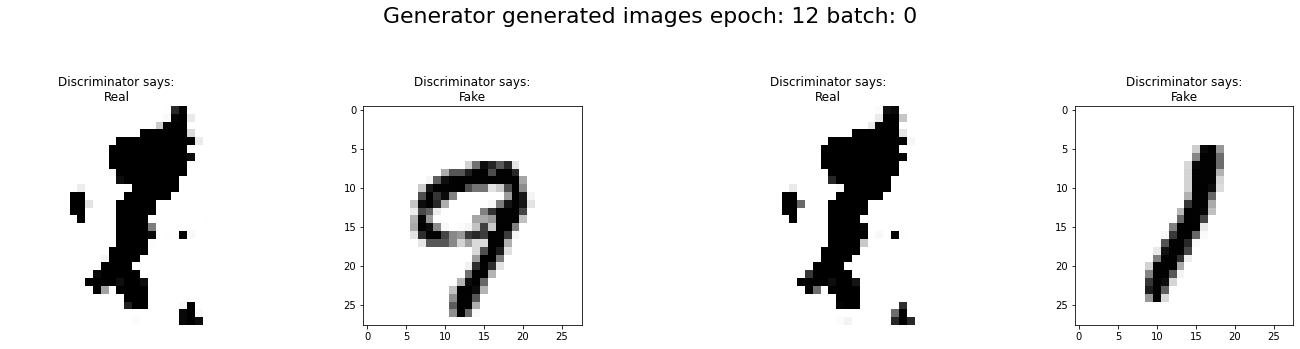

>Accuracy real: 27%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


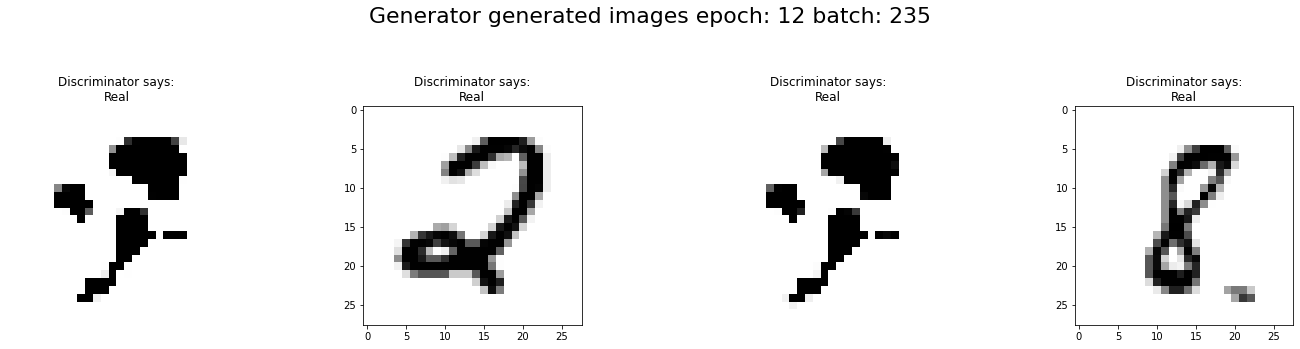

>Accuracy real: 49%, fake: 0%
------------------------------------------------------------------------------------------------------------------------


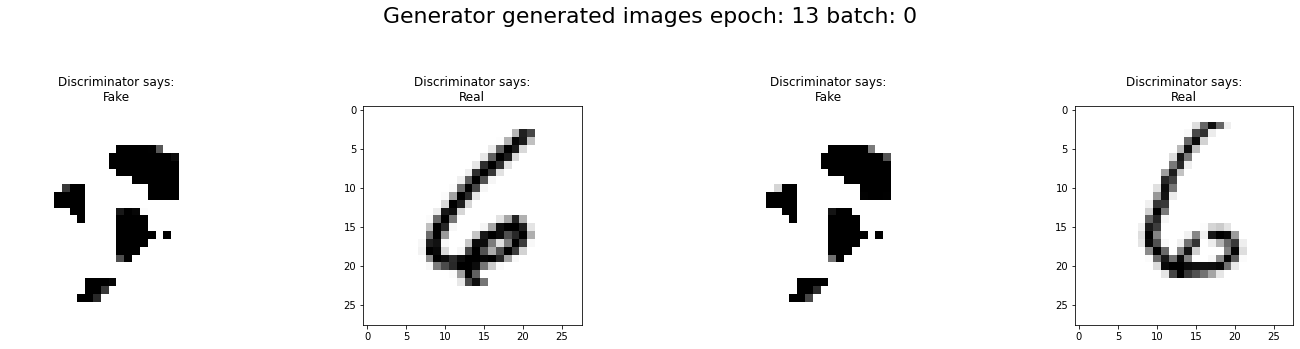

>Accuracy real: 96%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


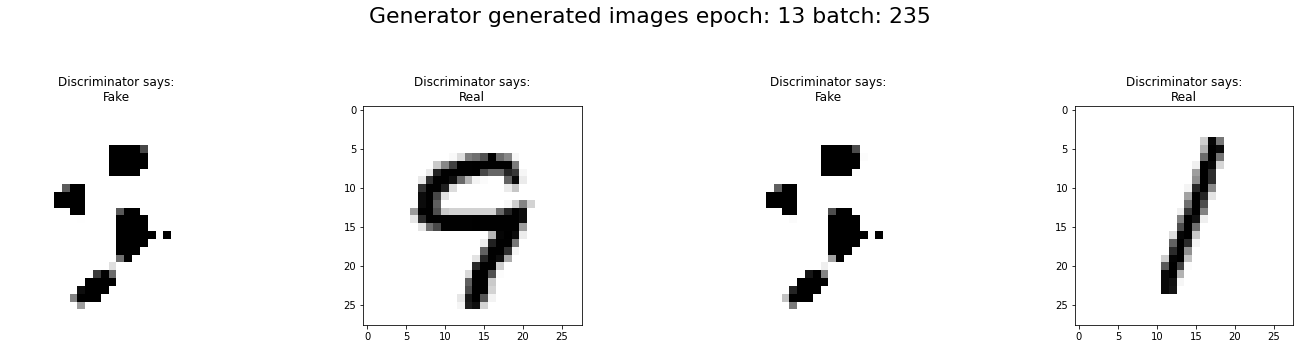

>Accuracy real: 92%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


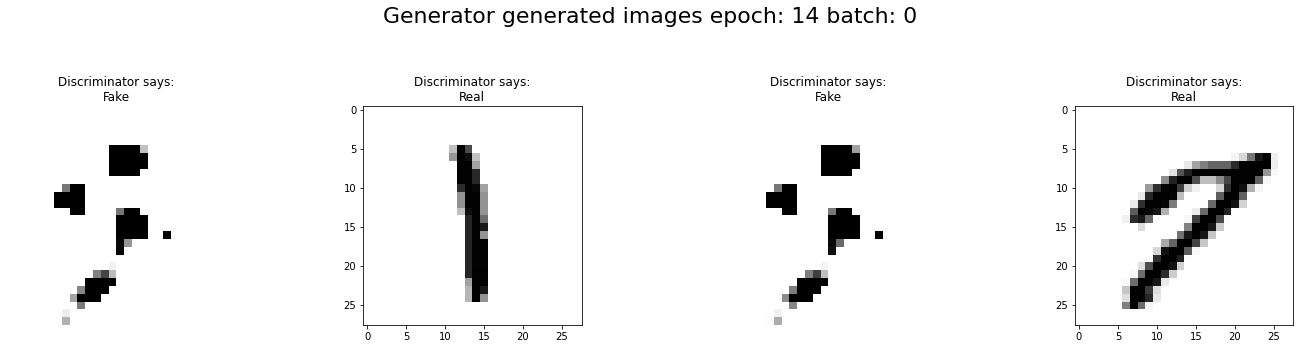

>Accuracy real: 99%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


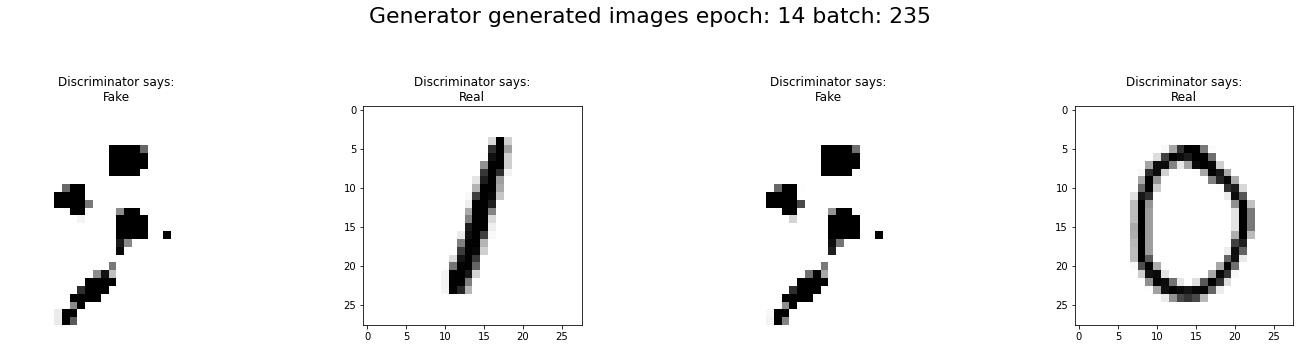

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


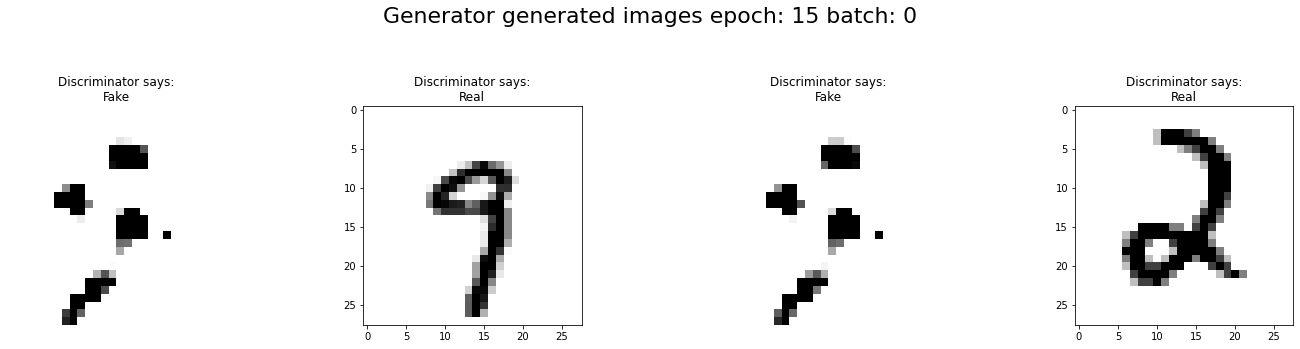

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


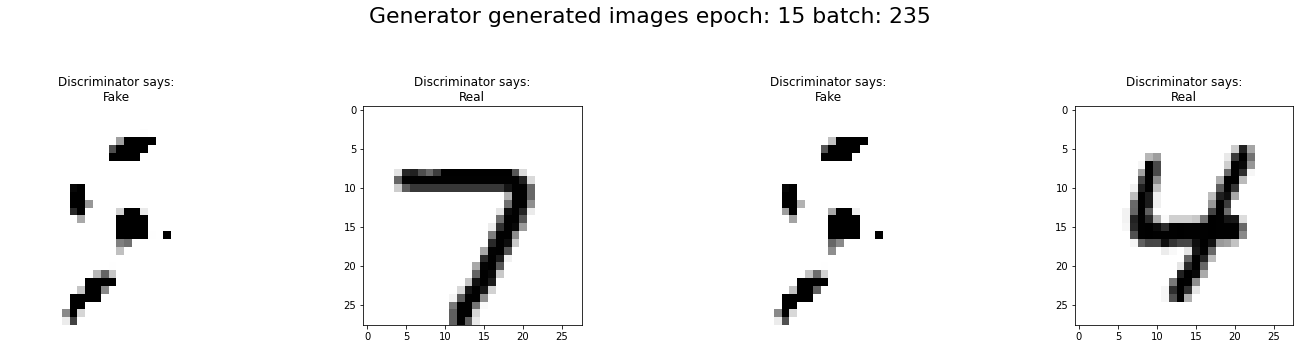

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


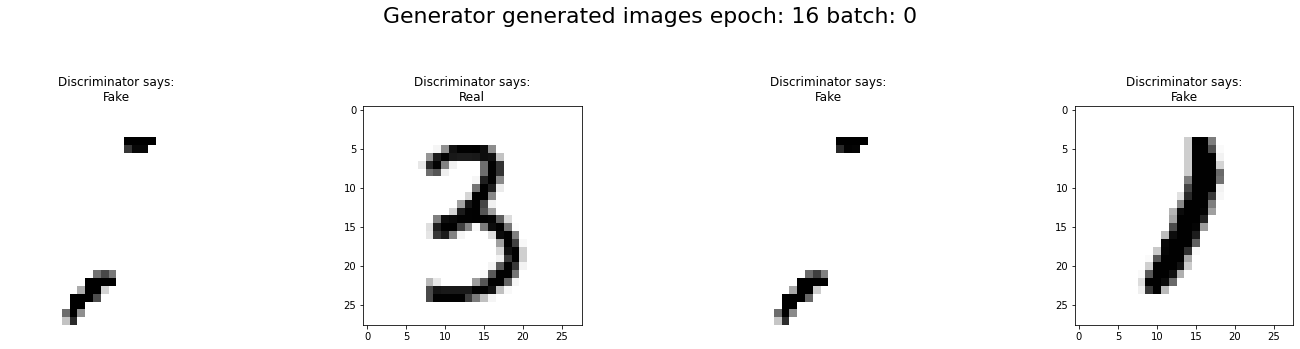

>Accuracy real: 92%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


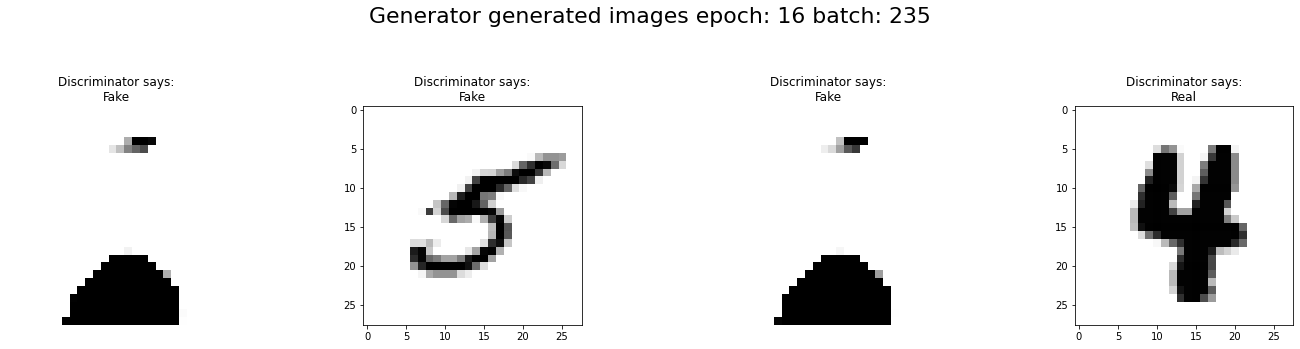

>Accuracy real: 84%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


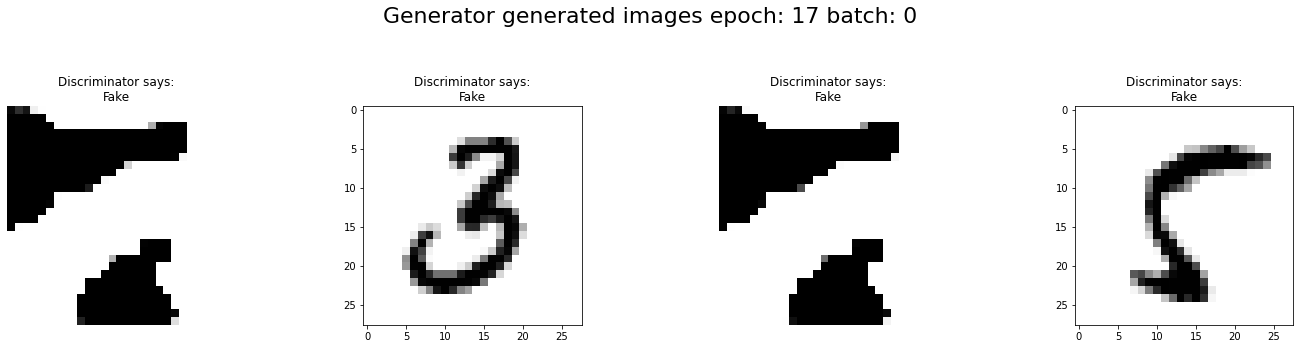

>Accuracy real: 25%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


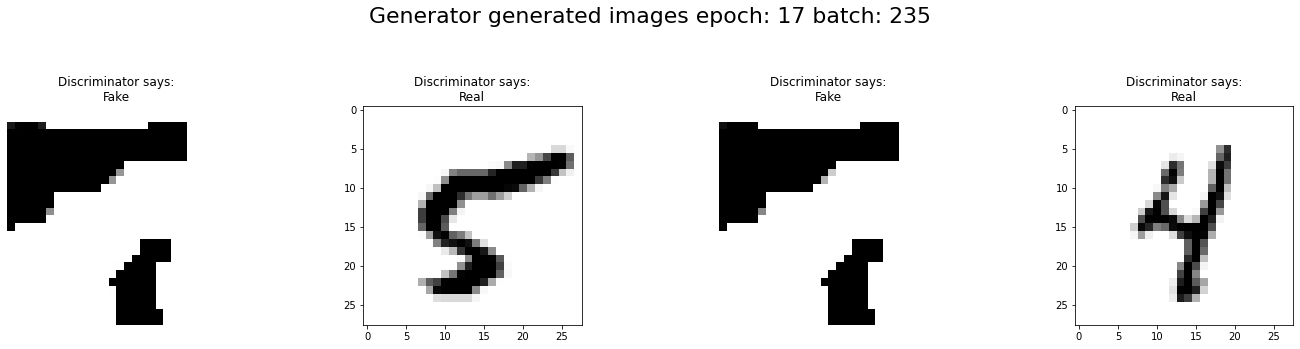

>Accuracy real: 97%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


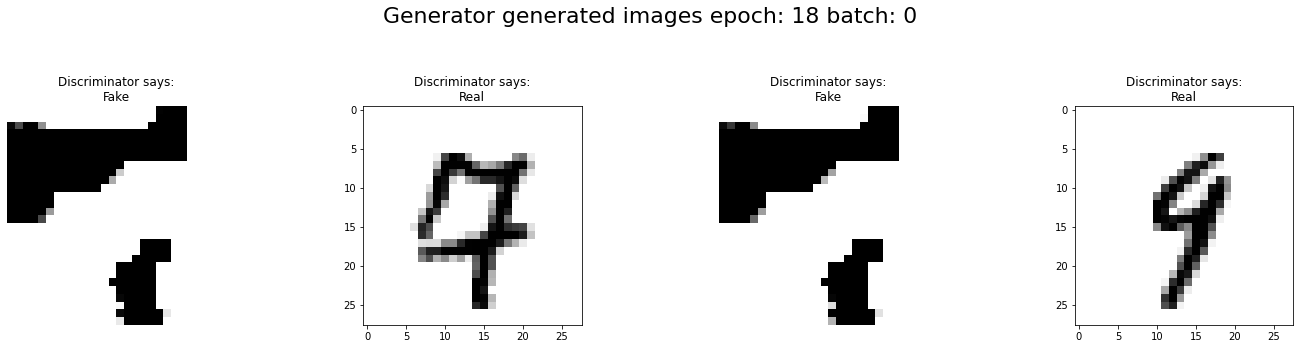

>Accuracy real: 98%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


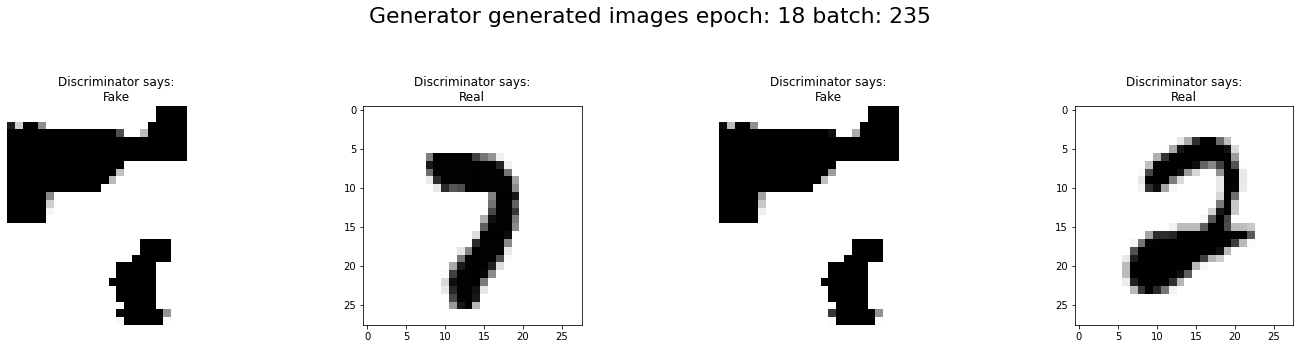

>Accuracy real: 98%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


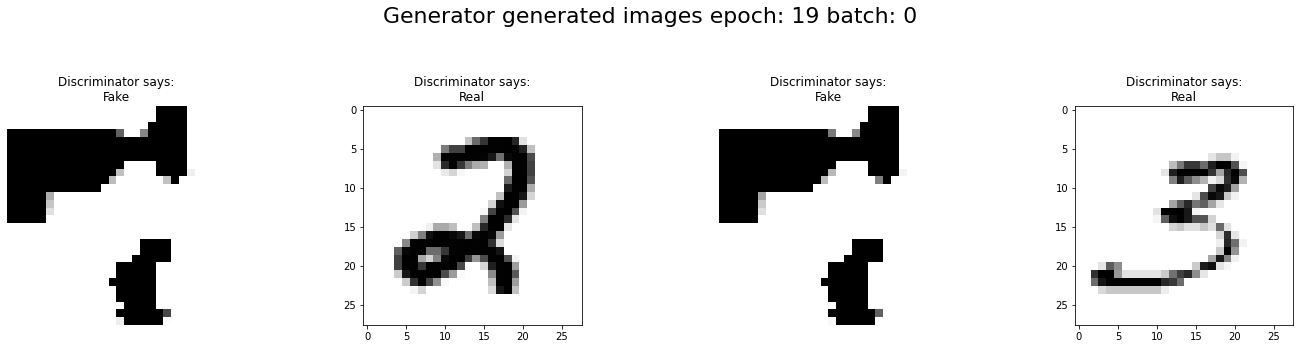

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


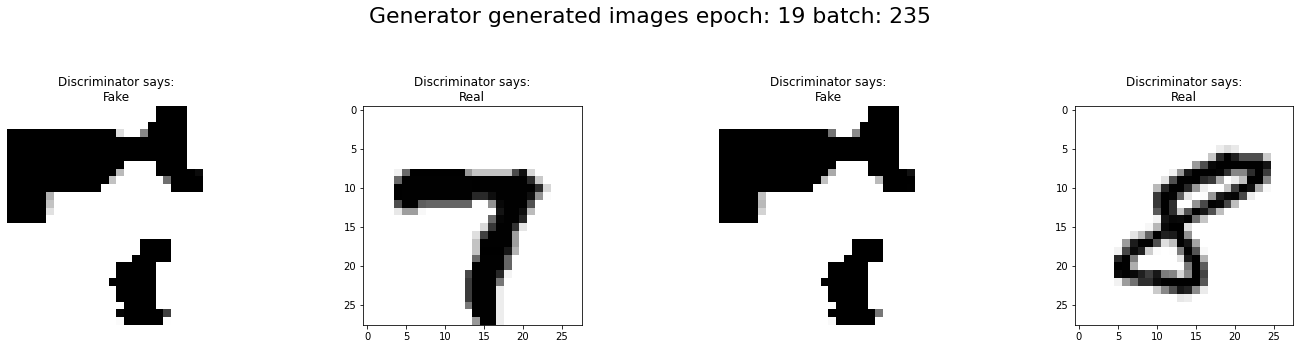

>Accuracy real: 100%, fake: 100%
------------------------------------------------------------------------------------------------------------------------


In [ ]:
batch_size=128 # tamaño del batch
plt.rcParams["figure.figsize"]=[20,4]
for epoch in range(20): #epochs a realizar
    for batch in range(int(x.shape[0]/batch_size)): #n° de batchs a realizar según el tamaño batch_size
      # train discriminator
      ix = np.random.randint(0, x.shape[0], batch_size) # generamos índices para samplear imágenes del dataset, sampleamos batch_size=128 datos
      x_real = x[ix]  # seleccionamos las imágenes
      noise = np.random.rand(noise_size * batch_size) # generamos ruido, según el tamaño de la entrada de nuestro generador
      noise = noise.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      x_false = generator_net.predict(noise) # generamos imágenes fake según el ruido
      y_real= np.ones((batch_size, 1)) # etiquetas real
      y_false = np.zeros((batch_size, 1)) #etiquetas fake
      x_train = np.concatenate((x_real, x_false)) # x_train-> imágenes reales + imágenes fakes
      y_train = np.concatenate((y_real, y_false)) # y_train-> etiquetas reales + etiquetas fakes
      response_dis = discriminator.train_on_batch(x_train, y_train) #train discriminator
      # train generator
      noise2 = np.random.rand(noise_size * batch_size) # generamos ruido nuevamente según el tamaño de la entrada de nuestro generador
      noise2 = noise2.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      response_gen = gan.train_on_batch(noise2 , np.ones((batch_size, 1))) # output is 1, as generator needs to convine discriminator (trainable false) w/ fake images from noise
      if batch%(235)==0: # cada cuánto plotear es ajustable
          # plot random generated images, discriminator image inputs and outputs, and losses and accuracies
          plt.suptitle("Generator generated images epoch: "+str(epoch)+" batch: "+str(batch), y=1.2,size=22)
          for i in range(2):
            plt.subplot(1, 4, 1 + 2*i)
            plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_false[20*i:20*i+1, :, :, :])[0,0],0))])
            plt.axis('off')
            plt.imshow(x_false[20*i].reshape((28,28,)), cmap='gray_r')
            plt.subplot(1, 4, 2 + 2*i)
            plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_real[20*i:20*i+1, :, :, :])[0,0],0))])
            plt.imshow(x_real[i, :, :, 0],cmap='gray_r')
          plt.tight_layout()
          plt.show()
          _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
          # prepare fake examples
          # evaluate discriminator on fake examples
          _, acc_false = discriminator.evaluate(x_false, y_false, verbose=0)
          # summarize discriminator performance
          print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_false*100))
          # plt.suptitle("Real images", y=1.2,size=22)
          # for i in range(5):
          #   plt.subplot(1, 5, 1 + i)
          #   plt.axis('off')
          #   # plt.title("Discriminator says:\n"+ ["Fake","Real"])
          #   plt.imshow(x_real[i, :, :, 0],cmap='gray_r')
          # plt.show()
          print("-"*120)

## 4.b) Mejora de GAN.

Utilizando el código modificado en el punto 4.b y lo aprendido durante el ramo. Modifique la arquitectura de la red neuronal a modo de obtener imágenes fake sean convincentes. Adicionalmente responda/comente según lo que observa durante el entrenamiento de la red neuronal.

* Explicar el comportamiento de la evolución de ambos desempeños y por qué no necesariamente esos valores representan que la red alcance su cometido
* Describir, teórica o práctiamente, que ocurriría si la red generadora no pudiera por algún motivo (divergencia en entrenamiento, excesivo _underfitting_, etc) generar imágenes razonables.
* Describir la contraparte de lo que ocurriría si la red discriminadora no pudiera aprender a diferenciar imagenes reales de ruido aleatorio.


Una vez teniendo una red entrenada a completitud, muestre varias imagenes generadas. ¿Se logra obtener imágenes convincentes?. Igualmente con la red entrenada, guarde el ruido aleatorio que origina dos números reconocibles distintos. ¿Qué ocurre si vemos las imagenes generadas por el generador al entregarle el vector del promedio entre los dos puntos?


Para entender en mayor profundidad el uso de GANs usamos como referencia:

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [ ]:
discriminator_net = Sequential() # Discriminador
discriminator_net.add(Conv2D(16, 3, strides=1, input_shape=x.shape[1:], padding='same')) #Recibe como entrada tanto imágenes generadas por el generador como imágenes del dataset
discriminator_net.add(MaxPooling2D(pool_size=(2,2)))
discriminator_net.add(Conv2D(32, 3, strides=1, padding='same'))
discriminator_net.add(MaxPooling2D(pool_size=(2,2)))
discriminator_net.add(Conv2D(48, 3, strides=1, padding='same'))

discriminator_net.add(Flatten())    #Flatten para pasar a una neurona de capa densa
discriminator_net.add(Dense(1,activation='sigmoid',use_bias=False))   # La salida estará entre 0 y 1.

discriminator_net.fit()



In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def plot(examples, n=5):
	# plot images
	for i in range(n * 2):       
		# define subplot
		pyplot.subplot(2, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.show()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      if (j+1)%78==0:
        print('epoch %d, %d/%d, discriminator loss=%.3f, generator loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      # evaluate the model performance, sometimes
    if (i+1) % 2 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
      plot(X_fake)
 

epoch 1, 78/234, discriminator loss=0.204, generator loss=1.203
epoch 1, 156/234, discriminator loss=0.494, generator loss=1.091
epoch 1, 234/234, discriminator loss=0.106, generator loss=2.427
epoch 2, 78/234, discriminator loss=1.011, generator loss=0.573
epoch 2, 156/234, discriminator loss=0.671, generator loss=0.644
epoch 2, 234/234, discriminator loss=0.736, generator loss=0.694
>Accuracy real: 47%, fake: 44%


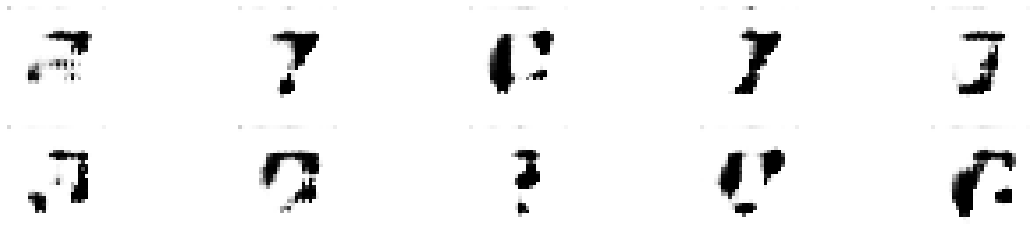

epoch 3, 78/234, discriminator loss=0.756, generator loss=0.697
epoch 3, 156/234, discriminator loss=0.650, generator loss=0.703
epoch 3, 234/234, discriminator loss=0.648, generator loss=0.811
epoch 4, 78/234, discriminator loss=0.671, generator loss=0.754
epoch 4, 156/234, discriminator loss=0.702, generator loss=0.733
epoch 4, 234/234, discriminator loss=0.682, generator loss=0.725
>Accuracy real: 71%, fake: 74%


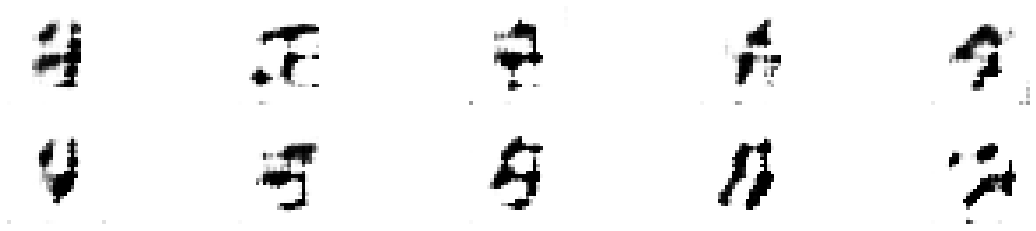

epoch 5, 78/234, discriminator loss=0.676, generator loss=0.756
epoch 5, 156/234, discriminator loss=0.692, generator loss=0.714
epoch 5, 234/234, discriminator loss=0.689, generator loss=0.706
epoch 6, 78/234, discriminator loss=0.698, generator loss=0.686
epoch 6, 156/234, discriminator loss=0.664, generator loss=0.741
epoch 6, 234/234, discriminator loss=0.667, generator loss=0.815
>Accuracy real: 35%, fake: 98%


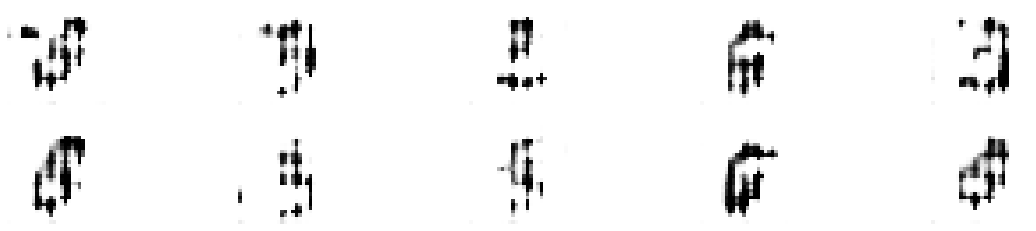

epoch 7, 78/234, discriminator loss=0.698, generator loss=0.769
epoch 7, 156/234, discriminator loss=0.702, generator loss=0.703
epoch 7, 234/234, discriminator loss=0.692, generator loss=0.706
epoch 8, 78/234, discriminator loss=0.686, generator loss=0.702
epoch 8, 156/234, discriminator loss=0.683, generator loss=0.702
epoch 8, 234/234, discriminator loss=0.684, generator loss=0.719
>Accuracy real: 54%, fake: 81%


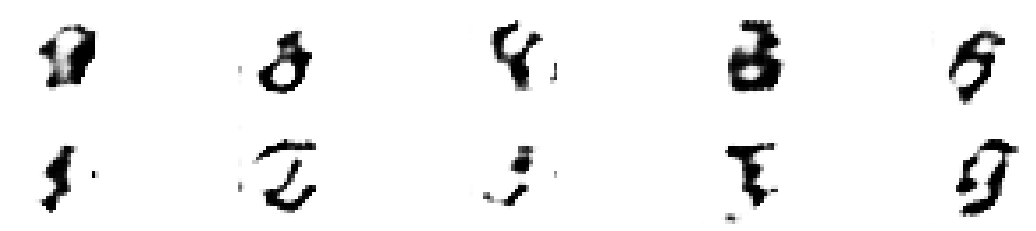

epoch 9, 78/234, discriminator loss=0.683, generator loss=0.684
epoch 9, 156/234, discriminator loss=0.689, generator loss=0.728
epoch 9, 234/234, discriminator loss=0.691, generator loss=0.735
epoch 10, 78/234, discriminator loss=0.686, generator loss=0.802
epoch 10, 156/234, discriminator loss=0.678, generator loss=0.714
epoch 10, 234/234, discriminator loss=0.676, generator loss=0.733
>Accuracy real: 63%, fake: 78%


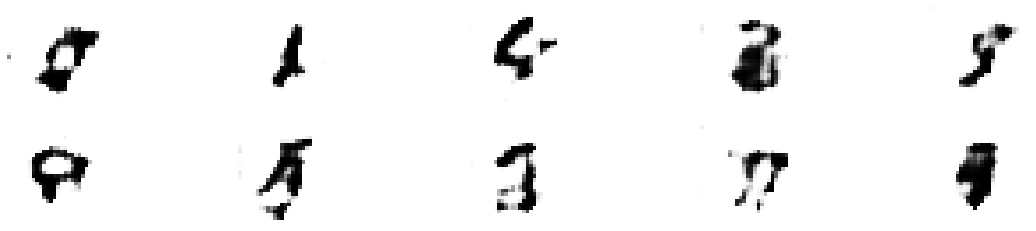

epoch 11, 78/234, discriminator loss=0.698, generator loss=0.683
epoch 11, 156/234, discriminator loss=0.654, generator loss=0.753
epoch 11, 234/234, discriminator loss=0.701, generator loss=0.688
epoch 12, 78/234, discriminator loss=0.689, generator loss=0.692
epoch 12, 156/234, discriminator loss=0.673, generator loss=0.730
epoch 12, 234/234, discriminator loss=0.676, generator loss=0.749
>Accuracy real: 35%, fake: 91%


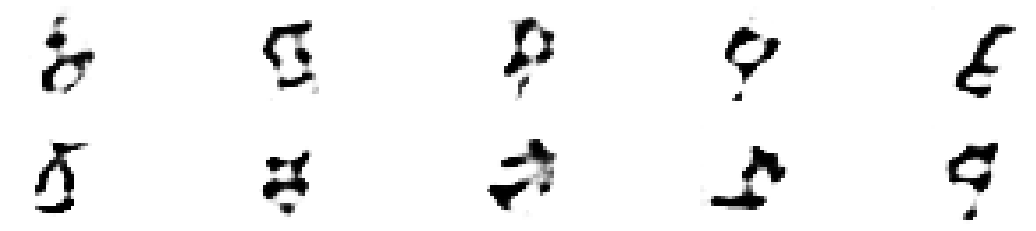

epoch 13, 78/234, discriminator loss=0.678, generator loss=0.666
epoch 13, 156/234, discriminator loss=0.677, generator loss=0.714
epoch 13, 234/234, discriminator loss=0.665, generator loss=0.682
epoch 14, 78/234, discriminator loss=0.671, generator loss=0.721
epoch 14, 156/234, discriminator loss=0.683, generator loss=0.691
epoch 14, 234/234, discriminator loss=0.692, generator loss=0.707
>Accuracy real: 60%, fake: 68%


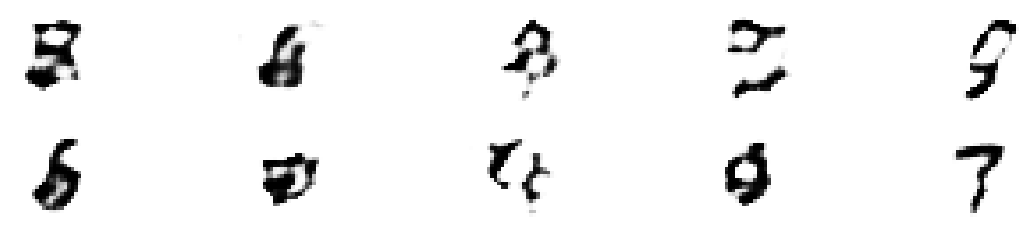

epoch 15, 78/234, discriminator loss=0.672, generator loss=0.747
epoch 15, 156/234, discriminator loss=0.686, generator loss=0.752
epoch 15, 234/234, discriminator loss=0.677, generator loss=0.735
epoch 16, 78/234, discriminator loss=0.674, generator loss=0.728
epoch 16, 156/234, discriminator loss=0.679, generator loss=0.705
epoch 16, 234/234, discriminator loss=0.691, generator loss=0.712
>Accuracy real: 61%, fake: 64%


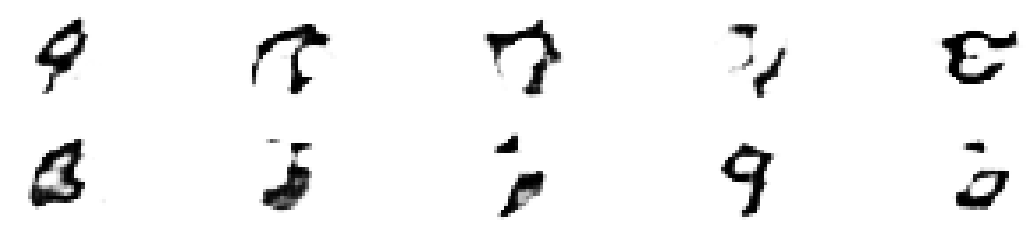

epoch 17, 78/234, discriminator loss=0.684, generator loss=0.708
epoch 17, 156/234, discriminator loss=0.680, generator loss=0.689
epoch 17, 234/234, discriminator loss=0.694, generator loss=0.690
epoch 18, 78/234, discriminator loss=0.681, generator loss=0.729
epoch 18, 156/234, discriminator loss=0.690, generator loss=0.690
epoch 18, 234/234, discriminator loss=0.688, generator loss=0.720
>Accuracy real: 62%, fake: 66%


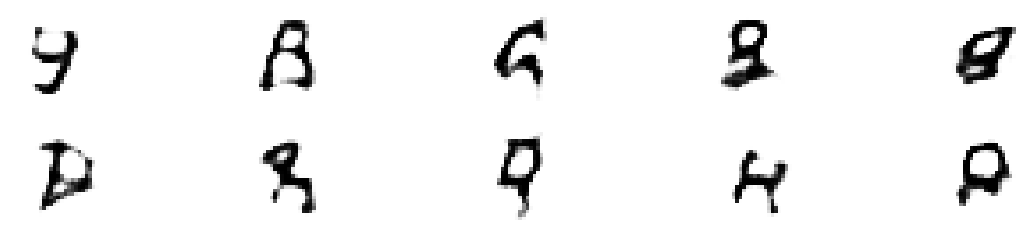

epoch 19, 78/234, discriminator loss=0.692, generator loss=0.715
epoch 19, 156/234, discriminator loss=0.691, generator loss=0.695
epoch 19, 234/234, discriminator loss=0.690, generator loss=0.770
epoch 20, 78/234, discriminator loss=0.686, generator loss=0.731
epoch 20, 156/234, discriminator loss=0.704, generator loss=0.753
epoch 20, 234/234, discriminator loss=0.679, generator loss=0.676
>Accuracy real: 90%, fake: 17%


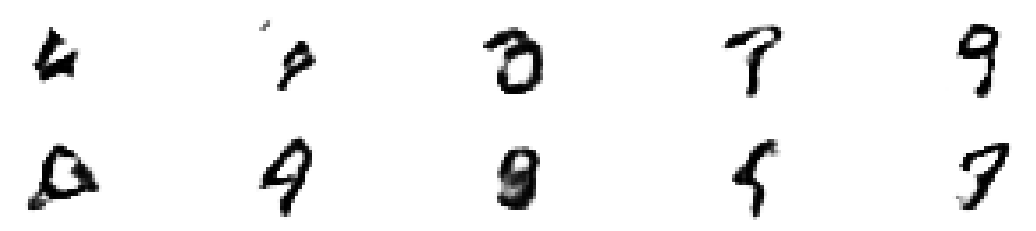

epoch 21, 78/234, discriminator loss=0.697, generator loss=0.699
epoch 21, 156/234, discriminator loss=0.688, generator loss=0.708
epoch 21, 234/234, discriminator loss=0.688, generator loss=0.704
epoch 22, 78/234, discriminator loss=0.690, generator loss=0.665
epoch 22, 156/234, discriminator loss=0.676, generator loss=0.742
epoch 22, 234/234, discriminator loss=0.679, generator loss=0.664
>Accuracy real: 99%, fake: 9%


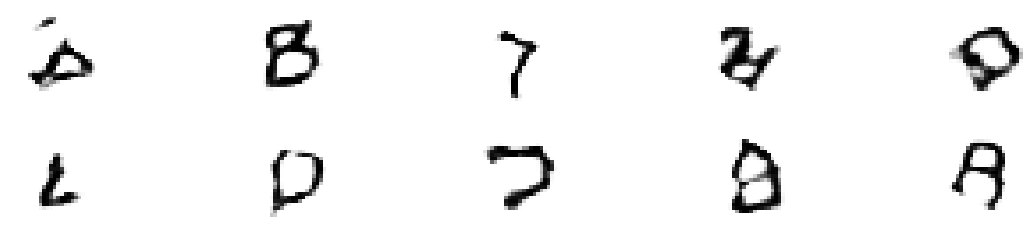

epoch 23, 78/234, discriminator loss=0.681, generator loss=0.748
epoch 23, 156/234, discriminator loss=0.687, generator loss=0.743
epoch 23, 234/234, discriminator loss=0.687, generator loss=0.687
epoch 24, 78/234, discriminator loss=0.694, generator loss=0.668
epoch 24, 156/234, discriminator loss=0.684, generator loss=0.736
epoch 24, 234/234, discriminator loss=0.683, generator loss=0.731
>Accuracy real: 20%, fake: 95%


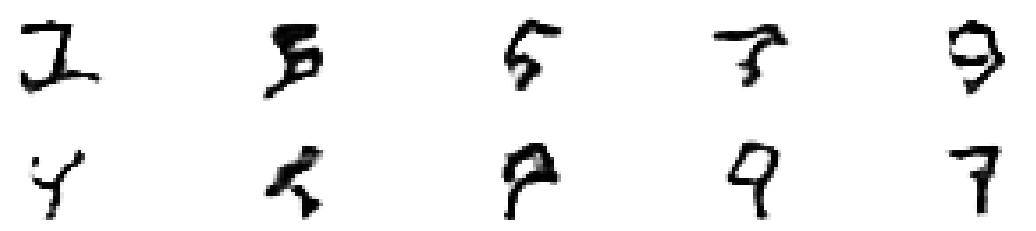

epoch 25, 78/234, discriminator loss=0.680, generator loss=0.665
epoch 25, 156/234, discriminator loss=0.685, generator loss=0.775
epoch 25, 234/234, discriminator loss=0.685, generator loss=0.655
epoch 26, 78/234, discriminator loss=0.679, generator loss=0.741
epoch 26, 156/234, discriminator loss=0.688, generator loss=0.694
epoch 26, 234/234, discriminator loss=0.693, generator loss=0.674
>Accuracy real: 96%, fake: 17%


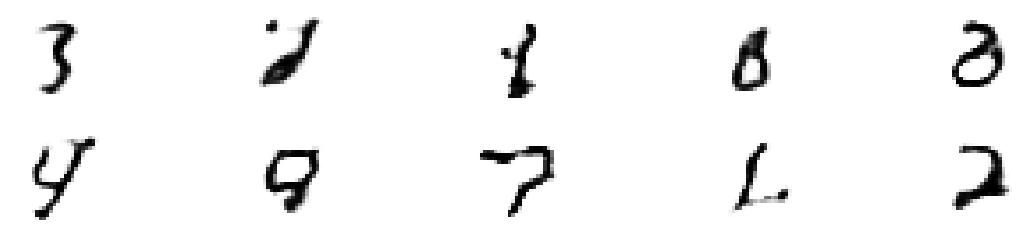

epoch 27, 78/234, discriminator loss=0.687, generator loss=0.701
epoch 27, 156/234, discriminator loss=0.677, generator loss=0.740
epoch 27, 234/234, discriminator loss=0.691, generator loss=0.683
epoch 28, 78/234, discriminator loss=0.684, generator loss=0.778
epoch 28, 156/234, discriminator loss=0.689, generator loss=0.732
epoch 28, 234/234, discriminator loss=0.702, generator loss=0.713
>Accuracy real: 62%, fake: 83%


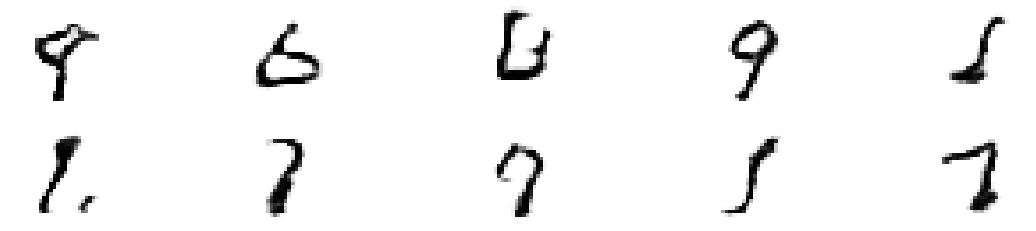

epoch 29, 78/234, discriminator loss=0.689, generator loss=0.672
epoch 29, 156/234, discriminator loss=0.711, generator loss=0.679
epoch 29, 234/234, discriminator loss=0.686, generator loss=0.665
epoch 30, 78/234, discriminator loss=0.683, generator loss=0.714
epoch 30, 156/234, discriminator loss=0.677, generator loss=0.725
epoch 30, 234/234, discriminator loss=0.686, generator loss=0.726
>Accuracy real: 34%, fake: 92%


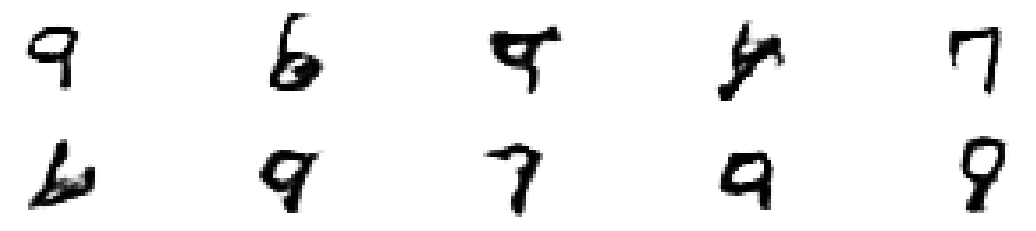

epoch 31, 78/234, discriminator loss=0.679, generator loss=0.667
epoch 31, 156/234, discriminator loss=0.672, generator loss=0.732
epoch 31, 234/234, discriminator loss=0.679, generator loss=0.720
epoch 32, 78/234, discriminator loss=0.681, generator loss=0.703
epoch 32, 156/234, discriminator loss=0.693, generator loss=0.723
epoch 32, 234/234, discriminator loss=0.683, generator loss=0.668
>Accuracy real: 97%, fake: 10%


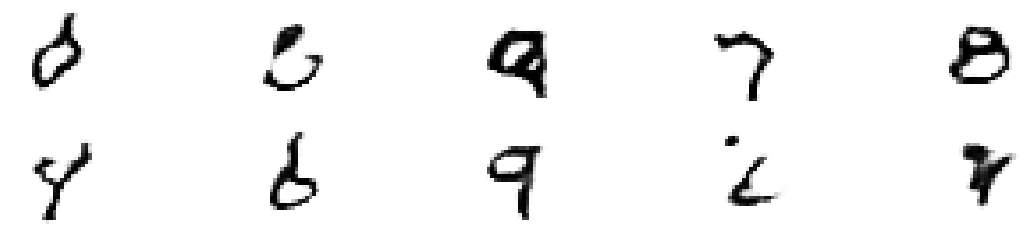

epoch 33, 78/234, discriminator loss=0.678, generator loss=0.721
epoch 33, 156/234, discriminator loss=0.684, generator loss=0.668
epoch 33, 234/234, discriminator loss=0.683, generator loss=0.758
epoch 34, 78/234, discriminator loss=0.689, generator loss=0.708
epoch 34, 156/234, discriminator loss=0.686, generator loss=0.671
epoch 34, 234/234, discriminator loss=0.690, generator loss=0.709
>Accuracy real: 63%, fake: 76%


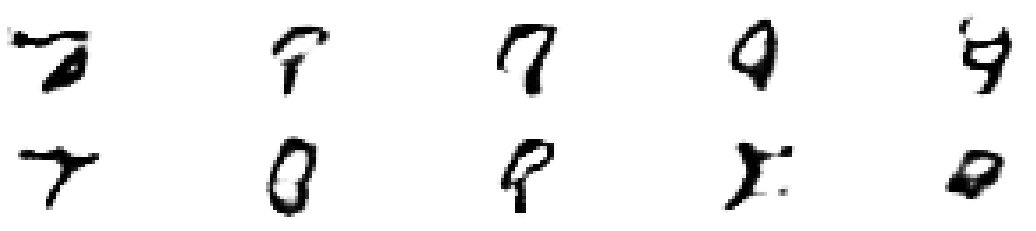

epoch 35, 78/234, discriminator loss=0.691, generator loss=0.696
epoch 35, 156/234, discriminator loss=0.682, generator loss=0.693
epoch 35, 234/234, discriminator loss=0.681, generator loss=0.712
epoch 36, 78/234, discriminator loss=0.690, generator loss=0.725
epoch 36, 156/234, discriminator loss=0.684, generator loss=0.704
epoch 36, 234/234, discriminator loss=0.684, generator loss=0.747
>Accuracy real: 26%, fake: 98%


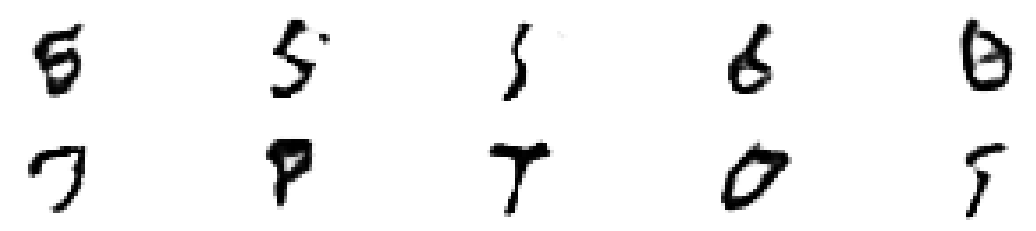

epoch 37, 78/234, discriminator loss=0.684, generator loss=0.725
epoch 37, 156/234, discriminator loss=0.681, generator loss=0.748
epoch 37, 234/234, discriminator loss=0.694, generator loss=0.709
epoch 38, 78/234, discriminator loss=0.690, generator loss=0.726
epoch 38, 156/234, discriminator loss=0.686, generator loss=0.769
epoch 38, 234/234, discriminator loss=0.681, generator loss=0.729
>Accuracy real: 64%, fake: 82%


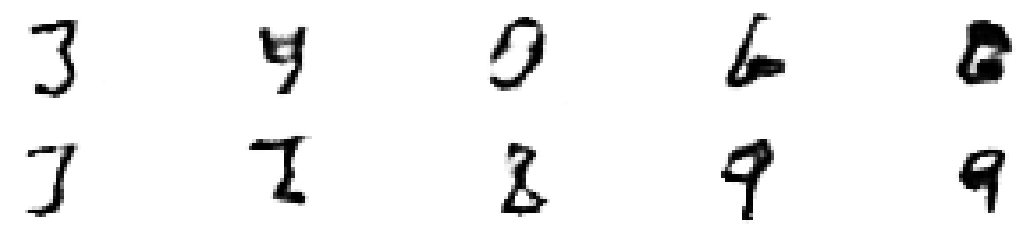

epoch 39, 78/234, discriminator loss=0.678, generator loss=0.720
epoch 39, 156/234, discriminator loss=0.689, generator loss=0.643


KeyboardInterrupt: ignored

In [ ]:
 # size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## Pregunta **Bonus**

* Proponga o investigue como realizaría las siguientes tareas:
    * A partir de una base de datos de imagenes RGB, entrenar una GAN que genere imágenes a color convincentes a partir de imagenes en blanco y negro, es decir que deduzca el color a partir de imagenes en blanco y negro.
    * A partir de una base de datos de cuadros de paisajes reales y las fotos correspondientes al cuadro, entrenar una GAN que permita transformar fotografias a cuadros y viceversa (puede utilizar más de 2 redes)
    * Proponga un problema que les parezca interesante y una estructura de GAN que le permitiría resolverlo